<a id="top"></a> 
# Application of Filtering to Scalp EEG Data

<div class="question">
    
_**Synopsis**_ 

**Data:** Ten 1 s trials of EEG data sampled at 1000 Hz.


**Goal:** Filter these data to identify an evoked response.


**Tools:** Fourier transform, convolution, magnitude response, frequency response, phase response.
    
</div>

* [Introduction](#.)
* [Data analysis](#data-analysis)
    1. [Visual inspection](#visual-inspection)
    2. [Spectrial Analysis](#spectral-analysis)
    2. [Evoked Response and Average Spectrum](#evoked-response)
    3. [Naive Filtering](#naive-filters)
    4. [More Sophisticated Filtering](#advanced-filters)
    5. [What’s Phase Got to Do with It?](#phase)
    6. [Analysis of the Filtered EEG Data](#analysis)
* [Summary](#summary)

## On-ramp: filtering field data in Python
We begin this module with an "*on-ramp*" to analysis. The purpose of this on-ramp is to introduce you immediately to a core concept in this module: how to filter field data in Python. You may not understand all aspects of the program here, but that's not the point. Instead, the purpose of this on-ramp is to illustrate what *can* be done. Our advice is to simply run the code below and see what happens ...

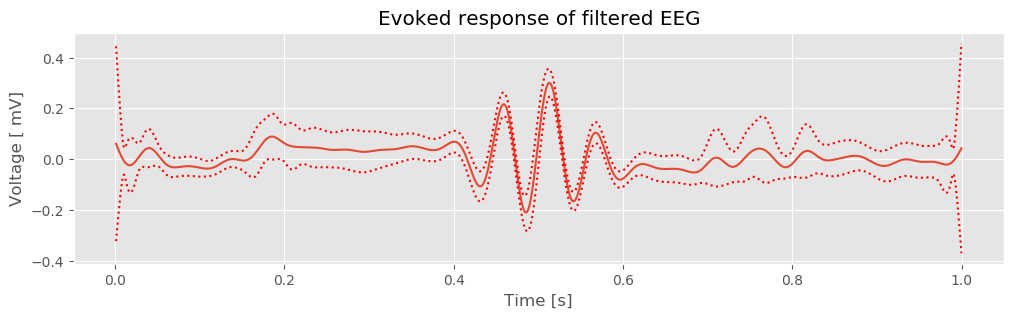

In [1]:
import numpy as np
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
%matplotlib inline

data = loadmat('EEG-1.mat')    # Load the data,
eeg = data['EEG']              # ... and define the EEG,
t = data['t'][0]               # ... and a time axis.

dt = t[1] - t[0]               # Define the sampling interval.
fNQ = 1 / dt / 2               # Determine the Nyquist frequency.
K = len(eeg)                   # Determine no. of trials.

n = 100                        # Define the filter order
Wn = 30 / fNQ                  # ... and specify the cutoff frequency,
b = firwin(n, Wn)              # ... build lowpass FIR filter,
                               # ... and zero-phase filter each trial
eeg_lo = np.array([filtfilt(b, 1, eeg[k]) for k in range(K)])

mn = eeg_lo.mean(0)            # Compute mean of filtered EEG across trials (ERP)
sd = eeg_lo.std(0)             # Compute std of filtered EEG data across trials.
sdmn = sd / np.sqrt(K);        # Compute the std of the mean.

plot(t, mn)                    # Plot the ERP of the filtered data
plot(t, mn + 2 * sdmn, 'r:');  # ... and the confidence intervals,
plot(t, mn - 2 * sdmn, 'r:');
xlabel('Time [s]')             # ... and label the axes.
ylabel('Voltage [ mV]')
title('Evoked response of filtered EEG')
show()


<div class="question">
    
**Q:** Try to read the code above. Can you see how it loads data, lowpass filters it, and then plots the ERP of the filtered data?

**A:** If you've never created and applied a filter before, that's an especially difficult question. Please continue on to learn this **and more**!

</div>

## Introduction
In previous case studies, we analyzed brain rhythms and discussed techniques to characterize these rhythms. Observed brain rhythms are often corrupted by noise. Sometimes this noise is obvious (e.g., electrical noise). In general, however, identifying the components of a brain signal that constitute signal versus noise is a difficult problem.

In this module, we develop techniques to isolate, emphasize, or remove rhythmic activity in neural field data. To do so we introduce a broad area of study and research: **filtering**. In general, filtering is a very common procedure in the analysis of neural data. Although it is typically considered a preprocessing step, how filtering is performed may make or break subsequent analysis. This is a vast area, and we focus here on only some of the important concepts and tools.

### Case study data
Our colleague recorded the electroencephalogram (EEG) from a human subject during a task. After performing the experiment, he analyzed the data with the hope of finding an evoked response over visual cortex. However, his initial analysis suggested no evoked response. He therefore asked us to assist in his data analysis. He provided us with the EEG data recorded on the scalp surface above the left occipital lobe of one subject. He would like to understand the rhythmic features that appear in these data during the recording, and in particular whether an evoked response can be detected. He provided us with ten trials of EEG data, each of duration 1 s, recorded during the subject’s response to a visual stimulus (a small flash of light).

### Goals
Our goal is to better understand whether an evoked response appears in the data. We first make a visual inspection of the data, using techniques we developed to [study evoked responses](../02). However, our main goal is to understand the fundamental procedures of filtering neural field data, and we examine filtering methods applied to these example EEG data. We start by developing an intuitive approach to filtering and then implement and apply more sophisticated methods. We explain procedures to visualize filter properties and the resulting impact on the input signal.

### Tools
In this chapter, we rely on the Fourier transform (and associated measures) to develop a basic understanding of filters. If you are not confident using the Fourier transform, we strongly recommend reviewing modules [3](../03) and [4](../04). This case study reinforces concepts in those modules and provides another opportunity to compute and to examine spectra, and to examine the relationships between the time and frequency domain representations of a time series. Upon completing this module, you should be familiar with basic filtering principles and methods to visualize the impact of filters, and equipped for further study and development of filtering procedures.

In [2]:
import numpy as np
from numpy import hanning, angle
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
%matplotlib inline

## Data analysis<a id="data-analysis"></a>

As always, let’s begin by looking at the data. To do so, we load the EEG data into Python and plot it:
<a id="fig:1">

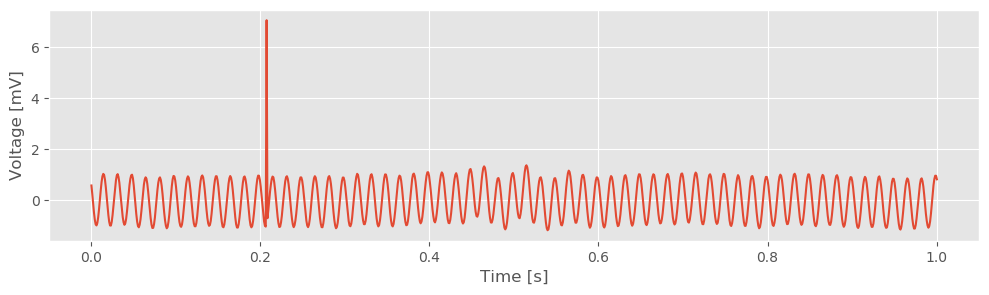

In [3]:
data = loadmat('EEG-1.mat')  # Load the EEG data
eeg = data['EEG']            # Extract the EEG variable
t = data['t'][0]             # ... and the t variable

rcParams['figure.figsize'] = (12, 3)  # Default to wide figures
plot(t, eeg[0])              # Plot the data from the first trial versus time
xlabel('Time [s]')           # Label the time axis
ylabel('Voltage [mV]')       # ... and the voltage axis
savefig('imgs/6-1.png')
show()

We note that the variable `eeg` is a matrix, with each row corresponding to a single trial. Inspection of the variable `eeg` reveals there are 10 trials (i.e., 10 rows) each consisting of 1,000 indices. We also note that the visual stimulus is delivered just after the start of the trial (at time 0.001 s, corresponding to index 0 of variable `t`), and the response is recorded for the subsequent 1 s (the time 1 s corresponds to index 999 of variable `t`).

<div class="question">
    
**Q.** What are the sampling interval and sampling frequency of the EEG data?
    
**A.** Inspection of the variable `t`, loaded into Python, reveals that the sampling interval is 0.001 s, or 1 ms, and the sampling frequency is therefore 1/(0.001 s), or 1000 Hz.
    
</div>

Visual inspection of the 1 s interval of the first trial suggests at least two distinct features. First, a rapid oscillation appears to occur, with amplitude near 1 mV. Second, a large deviation in voltage occurs (near 0.2 s). Additional slower oscillations may occur, although it’s difficult to tell from visual inspection alone.

<div class="question">
    
**Q.** Consider the fast rhythmic activity that dominates the EEG data plotted above. What is the frequency of this dominant rhythm? Do you observe an evoked response in this single trial? If so, where in time, and what features characterize the evoked response?
    
**A.** Careful counting of the number of peaks (or troughs) in the signal reveals that the fast rhythmic activity has a frequency of approximately 60 Hz. Visual inspection of the single-trial data does not suggest an evoked response (at least to the authors).
    
</div>

<div class="question">

**Q.** Examine other individual trials of the EEG data. Do you find features similar to those in the first trial?

</div>

[Back to top](#top)

### Spectral Analysis<a id="spectral-analysis"></a>

Initial visual inspection of the single-trial data suggests that a 60 Hz rhythm dominates each individual trial. To further characterize this observation, let’s compute the spectrum of a single trial of EEG data <sup><abbr title="We could instead write the sample spectrum because this equation uses the observed data to estimate the theoretical spectrum that we would see if we kept repeating this experiment, but this distinction is not essential to the discussion here.">note</abbr></sup>. We do so here for the first trial, and apply a Hanning taper before computing the spectrum (see [chapter 4](../04)):
<a id="fig:2"></a>

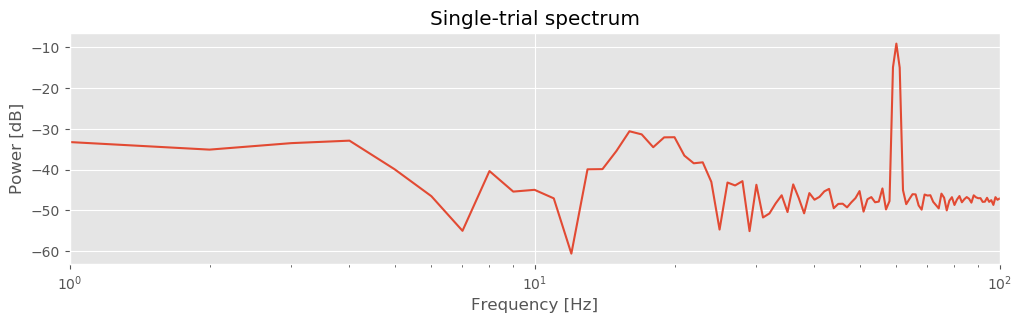

In [4]:
x = eeg[0]                # Load the first trial.
x = x - x.mean()          # Subtract the mean from the data.
dt = t[1] - t[0]          # Define the sampling interval.
T = t[-1]                 # Define the duration of the trial.
N = len(x)                # Define the number of points in the trial.

xh = hanning(N) * x       # Multiply data by Hanning window,
xf = rfft(xh)[:-1]        # ... compute Fourier transform,
Sxx = 2 * dt ** 2 / T * (xf * xf.conj());  #... and compute spectrum.

df = 1 / T;               # Determine frequency resolution.
fNQ = 1 / dt / 2;         # Determine Nyquist frequency.
faxis = np.arange(0, fNQ, df)              # Construct frequency axis

semilogx(faxis, 10 * np.log10(Sxx.real))   # Plot decibels vs frequency,
xlim([df, 100])           # ... in limited frequency range,
xlabel('Frequency [Hz]')  # ... with axes labeled.
ylabel('Power [dB]')
title('Single-trial spectrum')
savefig('imgs/6-2')
show()

Notice that in the second line of code, we remove the mean from the single trial of data. This is not always necessary but often useful; we are usually most interested in the rhythmic behavior of the EEG activity, not the changes in the mean signal. 

<div class="question">

**Q.** What is the resulting frequency resolution?

**A.** The total duration of a trial is 1 s. Therefore the frequency resolution is 1/(1 s) = 1 Hz. If this answer makes no sense, we recommend reviewing the case study in [chapter 3](../03).

</div>

The resulting spectrum reveals two important features. First, the power spectral density appears increased at lower frequencies compared to higher frequencies, that is, the spectrum tends to decrease with increasing frequency. This distribution of power is common in neural field data (e.g., [[He, et al., 2010]](https://doi.org/10.1016/j.neuron.2010.04.020)) and in other biological systems [[Bak, Tang, & Wiesenfeld, 1987]](https://doi.org/10.1103/PhysRevLett.59.381). Second, a large peak occurs at 60 Hz. This peak is consistent with the dominant rhythm apparent through visual inspection of the data in the first trial<a href="#fig:1" class="sup">fig<span><img src="imgs/6-1.png"></span></a>.

A 60 Hz peak is common in EEG data recorded in North America, where the alternating current in an electrical socket has frequency 60 Hz. We might also perhaps observe a second small peak between approximately 15 and 25 Hz. However, it’s not immediately apparent whether this peak represents a rhythm or a random fluctuation in the (noisy) spectrum. In any case, these initial spectral results are somewhat reassuring. The data exhibit characteristics we expect in typical scalp EEG data. Namely, the spectrum tends to decrease with frequency, and a large, sharp 60 Hz peak occurs, consistent with electrical noise.

<div class="question">

**Q.** Examine the spectrum of other individual trials. Do you find features similar to those in trial 1?

</div>

[Back to Top](#top)
### Evoked Response and the Average Spectrum<a id="evoked-response"></a>

Initial inspection of the features observable in the individual trials of EEG data has not been encouraging; the data appear to be dominated by 60 Hz line noise, with an occasional large-amplitude deviation. Through this initial inspection, it’s not clear whether an evoked response occurs in these data. We may therefore conclude that if an evoked response does occur in the data, the effect is weak and not apparent in a single trial. To further search for a weak evoked effect, let’s average the EEG responses across trials. In doing so, we hope that events unrelated to the stimulus will be reduced while responses evoked by the stimulus will be enhanced (see [chapter 2](../02)). More specifically, let’s compute the mean and standard deviation of the mean EEG response at each time across trials:
<a id="fig:3"></a>

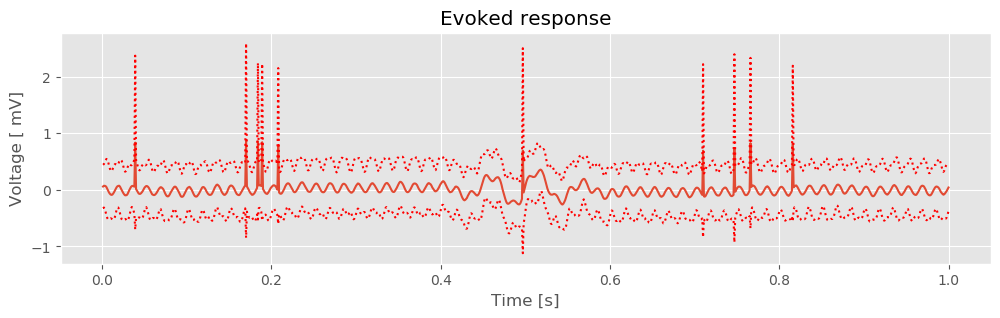

In [5]:
K = len(eeg)                   # Define variable to record no. of trials
mn = eeg.mean(0)               # Compute mean EEG across trials (ERP)
sd = eeg.std(0)                # Compute std of EEG data across trials.
sdmn = sd / np.sqrt(K);        # Compute the std of the mean.

plot(t, mn)                    # Plot the ERP,
plot(t, mn + 2 * sdmn, 'r:');  # ... and the confidence intervals,
plot(t, mn - 2 * sdmn, 'r:');
xlabel('Time [s]')             # ... and label the axes.
ylabel('Voltage [ mV]')
title('Evoked response')
savefig('imgs/6-3a.png')
show()

Visual inspection suggests three important features. First, the 60 Hz rhythm, which dominated the individual trial data, is less prominent here. Second, large and brief increases in voltage appear in the ERP throughout the 1 s interval (e.g., at times near 0.2 s and at times near 0.8 s). Third, an interesting event appears near time 0.5 s, where we observe a brief interval of rhythmic fluctuations. The mean voltage appears to increase and decrease approximately twice in 125 ms, corresponding to an approximate 16 Hz rhythm. These mean results suggest an evoked response near time 0.5 s. However, we also observe that the 95% confidence intervals of the ERP include zero; we therefore do not find evidence for a significant ERP.

In addition to the ERP, we also compute the trial-averaged spectrum: 
<a id="fig:3b"></a>

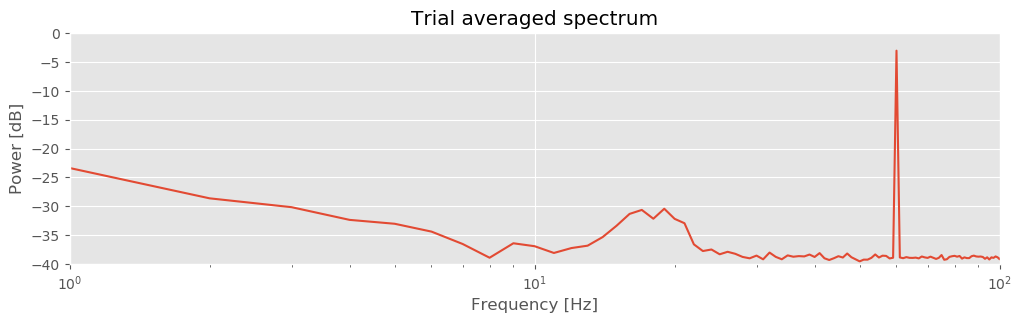

In [6]:
def spectrum(x, t, hann=True):
    '''
    Define a function that computes the power spectrum 
    for any given x (trial data) and t (time of samples).
    '''
    dt = t[1] - t[0]
    T  = t[-1]
    x  = x - x.mean()
    xh = hanning(N) * x if hann else x
    xf = rfft(xh)[:-1]
    Sxx = 2 * dt ** 2 / T * (xf * xf.conj())
    return Sxx.real

Sxx = [spectrum(trial, t, False) for trial in eeg] # Compute the spectrum for each trial.
Sxxmn = np.array(Sxx).mean(0)                      # Convert the result into an array and compute the mean.
semilogx(faxis, 10 * np.log10(Sxxmn))              # Plot the result in decibels vs frequency,
xlim([df, 100])                                    # ... in limited frequency range,
ylim([-40,0])                                      # ... and limited power range,
xlabel('Frequency [Hz]')                           # ... with axes labeled.
ylabel('Power [dB]')
title('Trial averaged spectrum')
savefig('imgs/6-3b.png')
show()

Compared to the <a href="fig:2" class="fig">single-trial spectrum<span><img src="imgs/6-2.png"></span></a>, the variability is greatly reduced in the <a href="fig:3b" class="fig">trial-averaged spectrum<span><img src="imgs/6-3b.png"></span></a>. By reducing the variability in this way, the rhythmic peak between 15 Hz and 25 Hz becomes more apparent. We also observe both the 60 Hz electrical noise peak and the trend of decreasing power spectral density with increasing frequency, as in the single-trial spectrum.

<div class="question">

**Q.** Given the initial analysis, what conclusions do you make regarding the EEG data?

**A.** The analysis of the single-trial and trial-averaged results suggests that 60 Hz electrical noise dominates the EEG signal. We observe this electrical noise directly in the voltage traces and as a prominent sharp peak in the spectrum. We have some suggestive observations that an interesting evoked response may occur in the data but no conclusive (i.e., significant) evidence. Perhaps if we can reduce the 60 Hz electrical noise, we can uncover a weak evoked response that is currently hidden by the 60 Hz signal. To reduce the 60 Hz signal, we next try to filter these data.

</div>

[Back to Top](#top)
### Naive Filtering<a id="naive-filters"></a>

In this section, we introduce some fundamental concepts related to filtering. An easy approach to filtering is simply to use packaged Python functions to implement standard filtering methods. However, this approach can be dangerous. If we treat the filter as a black box, then we may not understand what a filter actually does and when it might fail to perform as we hope. To gain intuition for filtering, we therefore begin with a naive approach. This approach uses understanding of the Fourier transform and spectrum, and allows us to investigate how a simple filter performs. We then attempt to improve this naive approach, again using notions familiar from the study of spectra in previous chapters (see chapters [3](../03) and [4](../04)). Through this approach we do not implement the most sophisticated or useful filters; in fact, we do not recommend using this approach in practice. But we develop a deeper understanding of what a filter actually does. Later, we use packaged functions to implement standard filtering approaches. Ideally, these built-in functions will seem more interpretable with the knowledge gained through the initial naive filtering investigations.

#### A Naive Rectangular Filter.

Initial analysis of the data suggests that the dominant rhythmic activity is 60 Hz electrical noise. This activity is reassuring (we expect it) but also a nuisance; because the line noise is so dominant, other interesting features of lower amplitude may be masked. To search further for a weak evoked response in the data, we must reduce the dominant 60 Hz rhythm.

We build our own filter to achieve this goal. The idea is simple: eliminate the 60 Hz rhythm from the EEG data. Recall that the Fourier transform converts a time domain representation of a signal to a frequency domain representation. Schematically, in symbols,

<a id="eq:1"></a>
$$ x_n \xrightarrow{\text{FT}} X_j \tag{1}$$

where $x_n$ is the data at each time index $n$, $X_j$ is the data at each frequency index $j$, and $FT$ denotes the Fourier transform. We also note that the inverse Fourier transform ($iFT$) converts the frequency domain representation of the data back to the time domain:

<a id="eq:2"></a>
$$ x_n \xleftarrow{\text{iFT}} X_j \tag{2}$$

With these concepts, we may define three steps for a naive rectangular filter:

 1. Move the observed EEG data to the frequency domain by computing the Fourier transform.
 2. Set the frequency domain components of the EEG signal at 60 Hz to zero.
 3. Move the altered data back to the time domain by computing the inverse Fourier transform.
 
We call this initial approach a naive rectangular filter. We call it “naive” because we’re using naive intuition to construct the filter; we propose to eliminate the 60 Hz activity in the frequency domain in the simplest way and explore the consequences. We call it “rectangular” because we isolate abrupt intervals in the frequency domain to eliminate. Let’s attempt this procedure and examine the impact on the EEG data. 

##### Step 1.
Our first step is to compute the Fourier transform of the EEG data. We focus specifically on the first trial; the same analysis can be performed on any individual trial. For completeness, we recompute some quantities from the previous sections:

In [7]:
x = eeg[0]        # Relabel the data from trial 1,
x = x - x.mean()  # ... subtract the mean from the data, 
xf = fft(x)       # ... and compute the FT

<div class="question">

**Q.** What are the dimensions of `xf`?

**A.** Note that `xf` is a vector with the same dimensions as the original EEG data from trial 1 (labeled `x`). Remember that computing the Fourier transform of a signal does not alter its dimensions. However, also note that `xf` is a complex vector, consisting of both real and imaginary parts.

</div>

##### Step 2.

We first define the frequency axis that corresponds to `xf`. We do so in the standard way implemented in previous chapters:

In [8]:
dt = t[1] - t[0]        # Define the sampling interval.
N = len(x)              # Define the number of points in a single trial.
faxis = fftfreq(N, dt)  # Construct the frequency axis

Here we use the function `fftfreq()`, which first lists the positive frequencies, and then the
negative frequencies. The construction is simimlar to traversing a circle whos angles are in the range of [$-\pi$, $\pi$]. If you start at zero, and rotate in a positive direction, you will eventually jump from $\pi$ to $-\pi$, and then continue. Let's visualize `faxis` computed with this function:

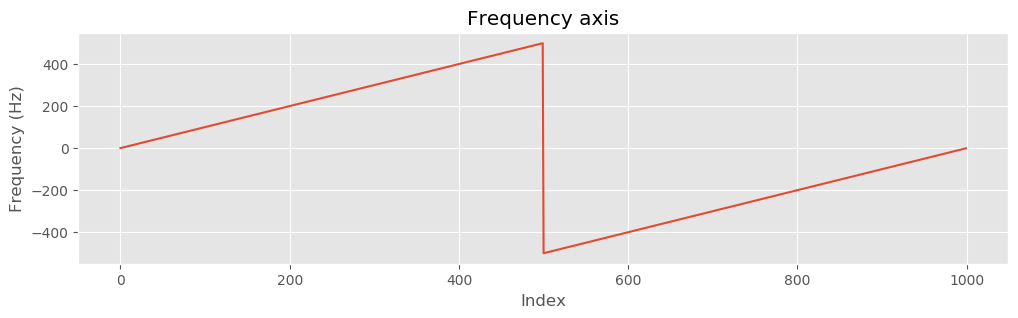

In [9]:
plot(faxis)
ylabel('Frequency (Hz)')
xlabel('Index')
title('Frequency axis')
show()

Notice that the frequency axis (`faxis`) consists of both positive and negative frequencies. When examining the spectrum, we typically ignore the redundant negative frequencies. However, when developing a filter, we must be careful to include all frequencies. The frequency domain representation of the EEG data requires both positive and negative frequencies, and we must adjust both to filter the signal. Also notice that we use `fftfreq()` to easily compute the frequency axis.

<div class="question">
    
**Q.** Consider the real and imaginary components of xf as a function of frequency. For each component, is the negative frequency axis a redundant representation of the positive frequency axis? *Hint*: Consider a plot of the imaginary component of `xf` versus frequency:

    plot(faxis, xf.imag)

What do you observe?

</div>

With the frequency axis defined, let’s now identify the indices corresponding to the 60 Hz rhythm we’d like to remove from the signal. Of the many approaches to perform this search, here’s one:

In [10]:
# Find interval near 60 Hz.
indices = (abs(faxis) >= 59) & (abs(faxis) <= 61)

In words, we find the indices where the absolute value of the frequency is between 59 and 61 (i.e., within 1 Hz of the target frequency, 60 Hz). 

<div class="question">

**Q.** Confirm that the values of `faxis` at the determined indices are less than, or equal to, 1 Hz from &plusmn;60 Hz.

**A.** Executing the command: 

    faxis[indices]
    
we find two intervals of values: (-61, -60, -59) Hz, and (59, 60, 61) Hz, consistent with our expectations.

</div>

With the indices surrounding the line noise frequency located, we’re ready to set the frequency domain components of the EEG signal at 60 Hz to zero. Let’s first define the filter in the frequency domain. This filter will have a value of 1 at all frequencies except near &plusmn;60 Hz, where we set the filter to 0. We then apply this filter to the frequency domain representation of the EEG data. By doing so, we set the (complex) values of `xf` (i.e., the frequency domain representation of the EEG data) to zero at the indices surrounding the line noise frequency. At all other indices, we leave `xf` unaltered (i.e., we multiply by 1).


In [11]:
rectangular_filter = np.ones_like(x)   # Define filter in frequency domain
rectangular_filter[indices] = 0        # ... set the filter at line-noise frequencies to zero
xf_filtered = xf * rectangular_filter  # ... apply filter to data

Before continuing, let’s visualize the filter and anticipate the impact on the frequency domain representation of the EEG data. We plot the variable `rectangular_filter`, the real part of `xf`, and their element-by-element product versus frequency.
<a id="fig:4"></a>

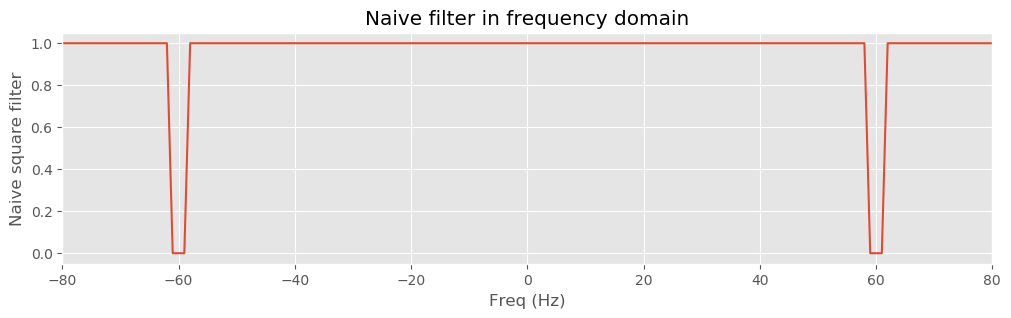

In [12]:
isorted = np.argsort(faxis)                       # Sort the frequency axis
plot(faxis[isorted], rectangular_filter[isorted]) # Plot rectangular filter vs frequency
xlabel('Freq (Hz)')                               # ... with axes labeled
ylabel('Naive square filter')
title('Naive filter in frequency domain')
xlim([-80, 80])
savefig('imgs/6-4.png')
show()

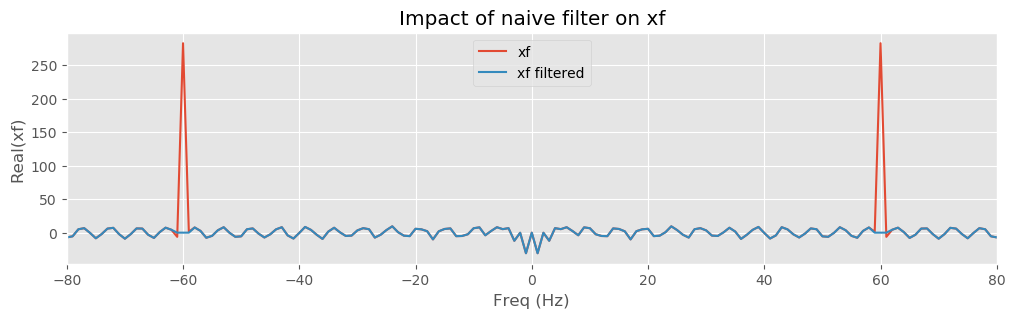

In [13]:
plot(faxis[isorted], xf.real[isorted], label="xf") # Plot real part of xf
                                                   # ... and real part of xf after filtering
plot(faxis[isorted], xf_filtered.real[isorted], label='xf filtered')
xlabel('Freq (Hz)')                                # ... with axes labeled
ylabel('Real(xf)')
title('Impact of naive filter on xf')
xlim([-80, 80])
legend()
show()

<div class="python-note">

Recall that `faxis` starts with the positive frequencies and then jumps to the negative frequencies. To display clearly the plots requires an additional step:

    isorted = np.argsort(faxis)
    
where `isorted` are the indices that sort the frequency axis in ascending order. In the code above we use these indices to plot `rectangular_filter`, `xf` and `xf_filtered` according to the sorted values of `faxis`.

</div>

We find that the filter maintains a value of 1 at all frequencies except for small intervals near &plusmn;60 Hz, where the filter has a value of 0. Considering the frequency domain representation of the EEG data, we observe that the real part of `xf` exhibits large peaks at &plusmn;60 Hz; these peaks correspond to the dominant 60 Hz rhythm apparent in the time domain EEG data. To apply the filter, we multiply the filter by the frequency domain representation of the data at each frequency. The result is shown in orange above. The peaks at &plusmn;60 Hz are eliminated because the value of the filter is set to 0 near these frequencies. All other frequency components in the EEG data are preserved, unaltered by the filter. The frequency domain representation of the EEG data also consists of an imaginary component, which we did not plot. However, the filter is applied to both the real and imaginary parts of `xf` through the element-by-element multiplication that defines `xf_filtered`.

##### Step 3.

Having eliminated the line noise in the frequency domain, we’re now ready to perform the third step of the naive rectangular filter. We apply the inverse Fourier transform, and transform the manipulated frequency domain signal back to the time domain:

In [14]:
xnew = ifft(xf_filtered)        # Compute iFT of freq domain data.

<div class="question">
    
**Q.** If the procedure behaves as expected, the resulting time domain signal `xnew` should be real and contain no imaginary components, consistent with the original EEG data. Is this so?

**A.** To verify this, consider the command 

    max(xnew.imag)
    
You should find a value equal to (or within numerical precision of) zero.
    
</div>

To understand the behavior of the new filtered signal in the time domain, let’s plot it. 
<a id="fig:5a"></a>

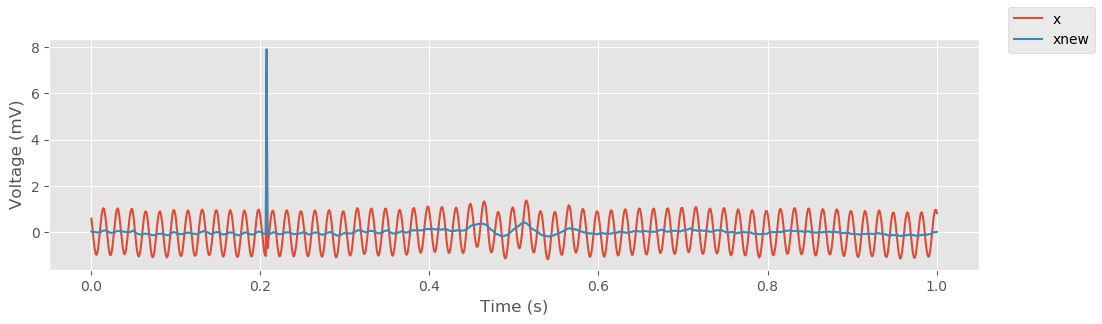

In [15]:
xnew = xnew.real                # The imag components are within numerical precision of 0.

fig, ax = subplots()            # Save the resulting plots for later use
plot(t, x, label='x')           # Plot the original signal
ax.plot(t, xnew, label='xnew')  # ... and the filtered signal
xlabel('Time (s)')              # ... with axes labeled
ylabel('Voltage (mV)')
fig.legend()
savefig('imgs/6-5a.png')
show()

An initial visual inspection suggests that the filter has the desired effect; the 60 Hz line noise is dramatically reduced. The same is true in the frequency domain. 
<a id="fig:5b"></a>

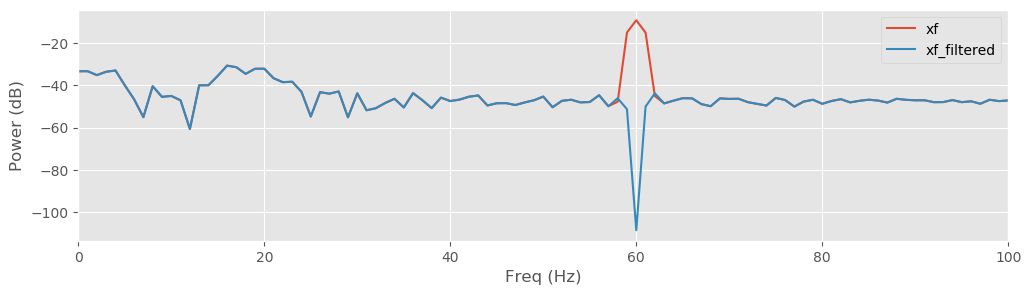

In [16]:
# Compute and plot the spectrum of the unfiltered signal.
plot(np.arange(0, fNQ, df), 10 * np.log10(spectrum(x, t)), label='xf')
# Compute and plot the spectrum of the filtered signal.
plot(np.arange(0, fNQ, df), 10 * np.log10(spectrum(xnew.real, t)), label='xf_filtered')
xlim([0, 100])
xlabel('Freq (Hz)')
ylabel('Power (dB)')
legend()
savefig('imgs/6-5b.png')
show()

The spectrum of the original signal matches the spectrum of the filtered signal at all frequencies except near 60 Hz, where the power spectral density of the filtered signal is dramatically reduced.

These initial observations suggest that the naive filter is performing quite well and achieving its intended purpose. Yet something is amiss. Consider an expanded view of the filtered signal near the large, brief increase in voltage at t &asymp; 0.2 s.
<a id="fig:5c"></a>

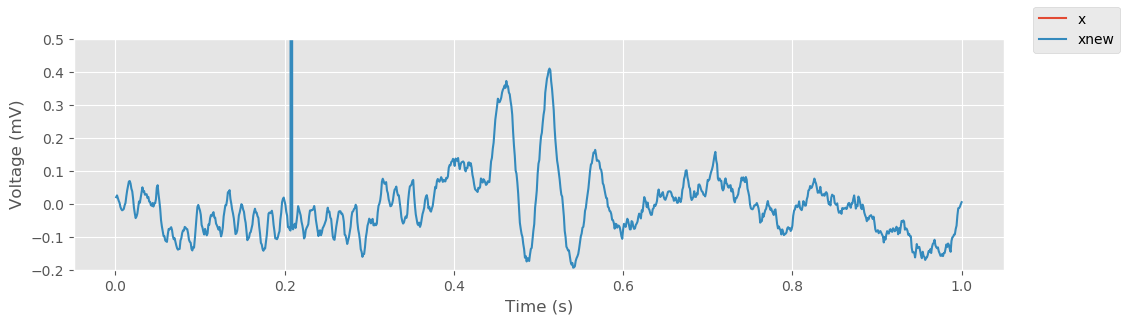

<Figure size 1200x300 with 0 Axes>

In [17]:
ax.lines.pop(0)         # Hide the plot of x
ax.set_ylim([-.2, .5])  # Zoom in on the y-axis
savefig('imgs/6-5c.png')
fig

<div class="question">
    
**Q.** Do any features stand out in the plot above? Consider the voltage fluctuations near the large, brief increase in voltage in the filtered EEG data. What do you observe?

**A.** Careful visual inspection suggests that near the abrupt voltage increase, small-amplitude oscillations emerge in the filtered signal. These oscillations appear to persist for an extended time interval around the abrupt amplitude deviation (at least 100 ms before and after the deviation) and have a period near 60 Hz.

</div>

We might interpret the small-amplitude, approximately 60 Hz transient rhythms surrounding each large-amplitude deviation in the EEG data as a biological phenomenon. Perhaps the brain generates these coupled dynamics (i.e., the spike and surrounding rhythmic activity) to achieve a particular function. If so, this would be an important scientific result. However, let’s maintain some skepticism regarding the initial filter we’ve developed. Perhaps our filtering procedure is producing these small-amplitude rhythms around each spike; if so, these rhythms are an artifact of our analysis, not a biologically generated phenomenon. In what follows, we continue to explore the impact of the initial filter and suggest ways to further test the naive rectangular filter’s performance.

#### Impulse response.

So far we’ve characterized the naive rectangular filter by its impact in the frequency domain. To further characterize this filter, we examine its behavior in the time domain by computing the *impulse response*. As the name suggests, the impulse response indicates the filter’s response to a simple input signal consisting of a single brief impulse. The impulse, although simple in the time domain, possesses spectral content across a wide frequency range; it takes many sinusoids to represent a sharp object like an impulse. In this way, the impulse probes how the filter behaves to input with rich spectral content. We implement the impulse response as follows:
<a id="fig:6a"></a>

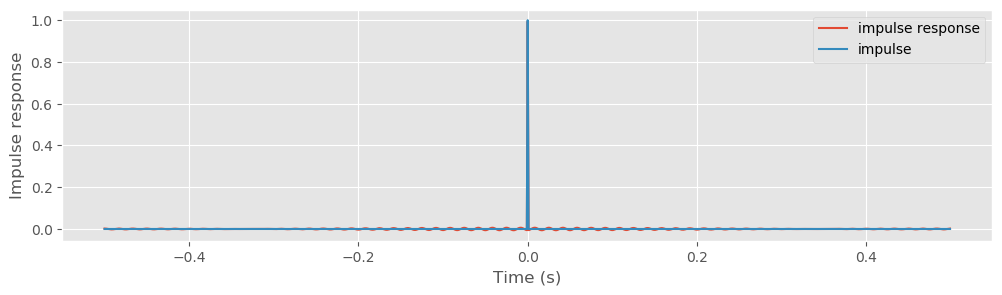

In [18]:
impulse = np.zeros_like(rectangular_filter)  # Define the input signal,
impulse[N // 2] = 1                          # ... with an impulse at the midpoint.
impulsef = fft(impulse) * rectangular_filter # Apply naive filter,
impulse_response = ifft(impulsef).real       # ... and iFT back to time domain
lag_axis = np.arange(-N // 2, N // 2) * dt   # Define lag axis,

fig, ax = subplots()                         # ... and plot the results.
ax.plot(lag_axis, impulse_response, label="impulse response")
ax.plot(lag_axis, impulse, label="impulse")
xlabel('Time (s)')
ylabel('Impulse response')
legend()
savefig('imgs/6-6a.png')
show()

Above, we see the original impulse and the impulse response (i.e., the result of applying the naive rectangular filter to the impulse). Visual inspection suggests how the filter affects the input signal in the time domain; we see that the filtered impulse consists of a large peak (centered at the time of the original impulse). By focusing on a small vertical range, we find that the peak at time 0 s is surrounded by smaller-amplitude fluctuations. 
<a id="fig:6b"></a>

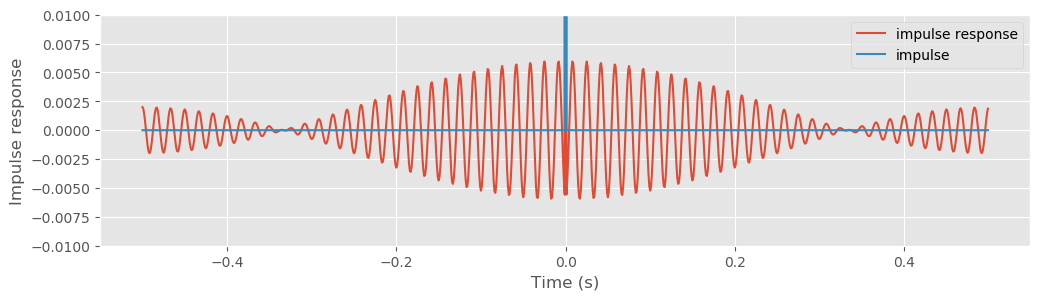

<Figure size 1200x300 with 0 Axes>

In [19]:
ax.set_ylim([-.01, .01])
savefig('imgs/6-6b.png')
fig

Although these fluctuations are small, we notice that they persist across all time indices examined. By focusing both the vertical and horizontal range, we observe that these fluctuations are periodic, with a period of 60 Hz. 

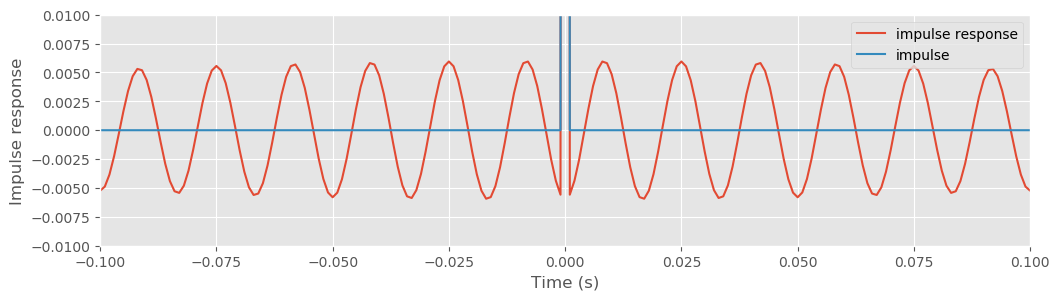

<Figure size 1200x300 with 0 Axes>

In [20]:
ax.set_xlim([-.1, .1])
savefig('imgs/6-6c.png')
fig

The impulse response provides important insights into the behavior of the naive rectangular filter: an impulse occurring in the original signal impacts all time points in the resulting filtered signal through small-amplitude 60 Hz fluctuations.

We are concerned about this impulse response for the naive rectangular filter. We find that an impulse, initially localized to a single index in time, becomes broadly distributed in time upon filtering. To further illustrate the impact of the naive rectangular filter, let’s consider a more direct method to apply a filter and compute the impulse response. Up to this point, we applied the filter by first transforming the input signal to the frequency domain, then performing an element-by-element multiplication of the input signal and filter, and finally transforming the result back to the time domain. We can avoid these transformations by remembering the following important fact.

<div class="question">

**Multiplication in the frequency domain is equivalent to convolution in the time domain.**

</div>

Therefore, as an alternative method for computing the impulse response, we convolve the impulse with the time domain representation of the filter. By doing so, we no longer need to transform to and from the frequency domain.

In [21]:
i_rectangular_filter = ifft(rectangular_filter).real  # Transform the filter to the time domain,
impulse_response_t = np.zeros_like(t)                 # ... and define the impulse response,
for ii in range(N):                                   # ... at each time point
    inds = [(ii - n) % N for n in range(N)]           # ... by computing the convolution
    impulse_response_t[ii] = (i_rectangular_filter[inds] * impulse).sum()

Notice that in this code we compute the convolution by hand. We do so to make explicit the computation performed. At each time index (`ii`), we multiply element by element the shifted rectangular filter in the time domain (note the definition of `inds`) by the impulse. At each shift, we sum the elements of this product; the result is the impulse response at time index `ii`. Conceptually, we may visualize the convolution as multiplying shifted versions of the filter by the signal:

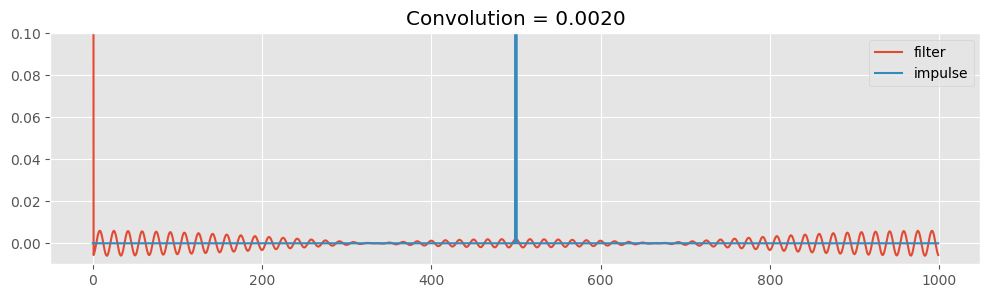

In [22]:
shift = 0                                          # Choose a shift,
inds = [(shift - n) % N for n in range(N)]         # ... and define the indices,
plot(i_rectangular_filter[inds], label="filter")   # ... to plot the shifted rectangular filter.
plot(impulse, label="impulse")                     # Plot the impulse,
legend()                                           # ... and compute the convolution at this shift.
title('Convolution = {:.4f}'.format(sum(i_rectangular_filter[inds] * impulse)))
ylim([-0.01, 0.1])
show()

When `shift = 0`, the filter begins with a peak at time index 0, and small oscillations are most apparent at lags near the beginning and end of the vector. As we (circularly) shift the filter, we move the filter peak to higher time indices (increase the value of `shift` in the code below to see this). When the filter peak reaches the impulse (`shift = 500`), the resulting summed product (i.e., the convolution) is large. Away from this time of large overlap, the resulting convolutions are small. The impulse response function is the result of these summed multiplications performed for all time shifts.

The resulting impulse response function computed in the time domain through convolution (variable name `impulse_response_t`, where `_t` denotes time) is identical to the impulse response function computed in the frequency domain through element-by-element multiplication (variable name `impulse_response`); we can see this by plotting `impulse_response_t` on the same axes where we previously plotted `impulse_response`.

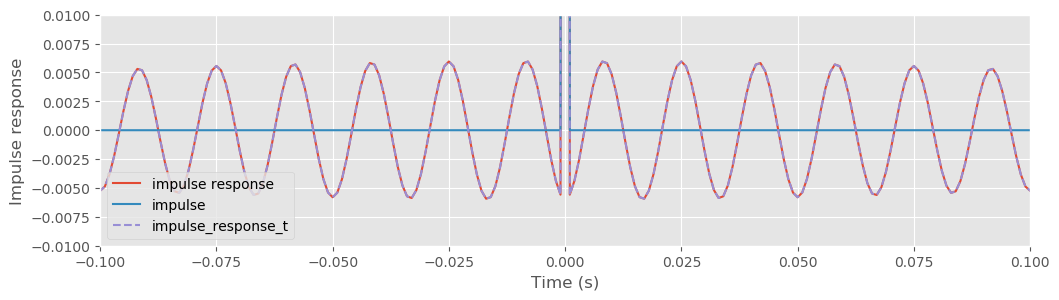

In [23]:
ax.plot(lag_axis, impulse_response_t, '--', label='impulse_response_t')
ax.legend()
fig

We have now examined two equivalent methods of filter application: through multiplication in the frequency domain or through convolution in the time domain. Both approaches provide insight into the impact of the naive rectangular filter. The frequency domain representation is easier to interpret. We designed this filter in the frequency domain to eliminate signal components near 60 Hz, which we implemented through an abrupt decrease in the frequency domain representation of the filter. It’s relatively easy to envision that this filter eliminates signal features near &plusmn;60 Hz and preserves features at other frequencies<a href="#fig:4" class="fig"><sup>fig</sup><img src="imgs/6-4.png"></a>.

The time domain representation of the naive rectangular filter is more complicated. While the impact of the filter in the frequency domain is limited, the impact in the time domain is broad. The impulse response decays at times away from the impulse; however, these contributions do remain. This example illustrates the necessary trade-off between the time and frequency domains. Namely, the sharp transition bands, or roll-off in the frequency domain (i.e., the nearly vertical rectangular-shaped transitions) correspond to a broad impulse response function that extends over many lags in the time domain. There’s no escaping this fact: the sharper we make the filter’s transitions in the frequency domain, the broader its effects in time. Again, we make this trade-off to implement the sharp roll-off of the naive rectangular filter; the transition band is narrow (a precipitous drop) in frequency and therefore requires many values in time.

Through the interpretation of filtering as convolution in time, we gain additional insight into the naive rectangular filter’s impact. When we looked closely, we identified suspicious behavior in the; we found that after filtering, the large-amplitude discharge was surrounded by small-amplitude oscillations with frequency near 60 Hz. Under the interpretation of filtering as convolution, we expect that a sudden large change in the input signal (i.e., the brief discharge in the EEG) will clearly impact the resulting filtered signal across an extended interval of time. Indeed, because the brief EEG discharge is so large, the small amplitude oscillations surrounding the central peak of the impulse function are apparent in the filtered EEG signal. For these brief large-amplitude peaks in the EEG data, the temporal impact of the filter is obvious in the filtered signal. However, this temporal impact occurs throughout the filtered signal; using the naive rectangular filter, each time point in the original signal impacts every time point in the [filtered signal](#fig:5c)<span class="fig"><sup>fig</sup><img src="imgs/6-5c.png"></span>.

We conclude this section by noting that these results are analogous to our discussion of the rectangular window function in [chapter 4](../04). In that chapter, we applied a rectangular taper in the time domain and showed that this produced broad effects in the frequency domain. Here, we instead apply an (inverted) rectangular taper in the frequency domain and find broad effects in the time domain. The fundamental concept is that the Fourier transform of a sharp transition in one domain (in this case, the abrupt edge of a rectangular taper) produces broad effects in the other domain.

[Back to Top](#top)
#### A naive Hanning filter.

In the previous section, we developed and applied a naive rectangular filter. We used the word “rectangular” to indicate the rectangular shape of the [filter](#fig:4)<span class="sup">fig<img src="imgs/6-4.png"></span> in the frequency domain. Although well-behaved in the frequency domain, the naive rectangular filter produces undesired effects in the time domain; namely, the filter’s sharp transitions in the frequency domain produce wide-ranging effects in the time domain. These long-range temporal effects are an unwanted feature of the filter. To reduce these effects, we propose an alternative filter that softens the sharp transitions in the frequency domain and makes these transitions more gradual. The idea is simple: replace the rectangular function in the original naive filter with a different, smoother function. In what follows we implement many of same procedures employed in the previous section and interpret how these changes affect the filtered EEG data.

Let’s begin our filter design in the frequency domain. Our goal is to eliminate the 60 Hz component (i.e., the electrical noise) from the EEG signal without introducing long-lasting temporal effects. To do so, instead of the naive rectangular function employed in our first filter, we’ll use a smooth Hanning function (first introduced in our computations of the spectrum in [chapter 4](../04)). First, we need to load the data and identify the indices corresponding to &plusmn;60 Hz, and then apply a Hanning window centered at each of these indices. Some of the following commands are redundant with commands we used previously, but they are repeated here for completeness.

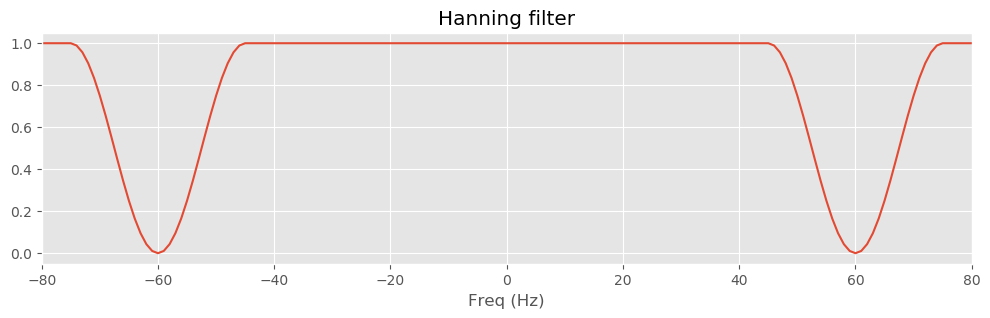

In [24]:
data = loadmat('EEG-1.mat')  # Load,
eeg = data['EEG']            # ... the EEG data,
t = data['t'][0]             # ... and the time axis.
x = eeg[0]                   # Analyze the first trial.
dt = t[1] - t[0]             # Define the sampling interval.
N = len(x)                   # Define the no. of points in a single trial.
df = 1 / (N * dt)            # Determine the frequency resolution.
fNQ = 1 / dt / 2             # Determine the Nyquist frequency.
faxis = fftfreq(N, dt)       # Construct the frequency axis.

win = 15                     # Set the size of the Hann window,
                             # ... and find indices within win of 60 Hz.
inds = (abs(faxis) >= (60 - win * df)) & (abs(faxis) <= (60 + win * df))

hann_filter = np.ones_like(t) # Define filter in frequency domain.
hann_filter[inds] = np.hstack([1 - hanning(2 * win + 1), 1 - hanning(2 * win + 1)])

isorted = np.argsort(faxis)                  # Sort the frequency axis.
plot(faxis[isorted], hann_filter[isorted])   # Plot the filter.
xlim([-80, 80])
xlabel('Freq (Hz)')
title('Hanning filter')
savefig('imgs/6-8a')
show()

In this code, we load the EEG from the first trial (variable `x`) and create the frequency axis (variable `faxis`) to find the indices that correspond to frequencies at &plusmn;60 Hz. At these indices, we center a Hanning window, which sets the filter to 0 at &plusmn;60 and gradually returns to 1 away from these values (the parameter `win` sets the width of the window).

<div class="question">

**Q.** Plot the original naive rectangular filter on top of the new Hanning filter. Compare the frequency domain representations of the two filters. What differences do you observe?

**A.** Although both filters decrease to 0 near ±60 Hz, the Hanning filter returns gradually to 1, while the rectangular filter rapidly changes from 0 to 1. In other words, the roll-off is more gradual in the Hanning filter compared to the square filter.

</div>

Let’s also examine the time domain representation of the new Hanning filter. To do so, we compute the impulse response.
<a id="fig:8b"></a>

In [25]:
def convolution(impulse, filt):
    '''
    Compute the impulse response of a filter (given in the 
    time domain) using convolution.
    '''
    N = len(impulse)
    response = np.zeros_like(impulse)
    for ii in range(N):
        inds = [(ii + n) % N for n in range(N)]
        response[ii] = sum(impulse[inds] * filt)
    return response

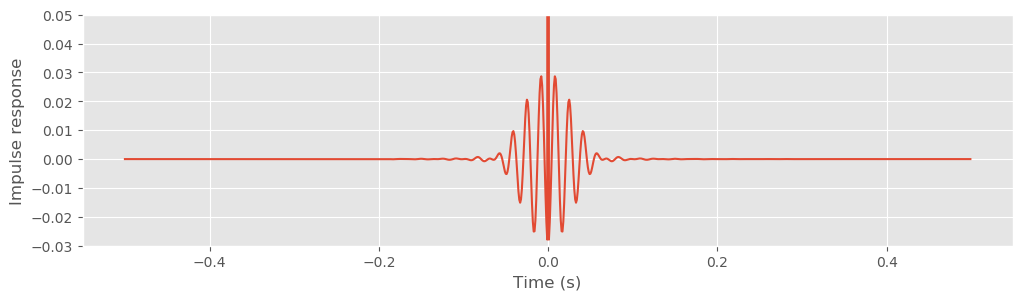

In [26]:
impulse = np.zeros_like(x)              # Define the input signal,
impulse[N // 2] = 1                     # ... with impulse at the midpoint
i_hann_filter = ifft(hann_filter).real  # Transform filter to time domain,
                                        # ... and compute the impulse response by convolution.
impulse_response_t = convolution(i_hann_filter, impulse)
lag_axis = np.arange(-N/2, N/2) * dt    # Define the lag axis for plotting
plot(lag_axis, impulse_response_t)      # Display the result
xlabel('Time (s)')
ylabel('Impulse response')
ylim([-.03, .05])
savefig('imgs/6-8b')
show()

In this code, we first define the impulse signal and then convolve this impulse with the Hanning filter transformed to the time domain (using `ifft`).

<div class="question">
    
**Q.** Plot the time domain representation of the original naive rectangular filter on top of that of the new Hanning filter. Compare the two. What differences do you observe?

**A.** To answer this question, execute the commands below. You'll find that both filters exhibit a large peak at time 0 s and are surrounded by small-amplitude 60 Hz oscillations. Compared to the naive rectangular filter, these oscillations are initially larger for the proposed Hanning filter. However, these oscillations quickly decay for the Hanning filter; after ±50 ms, the Hanning filter remains near zero.

</div>

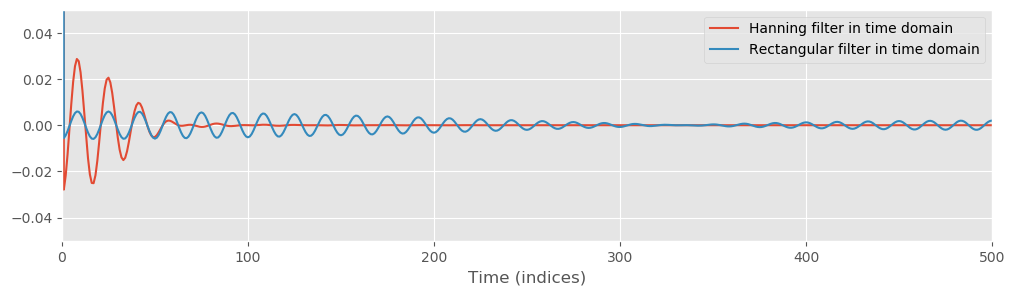

In [27]:
# Plot the time domain representations of the naive rectangular and Hanning filters.
plot(ifft(hann_filter).real,        label="Hanning filter in time domain")
plot(ifft(rectangular_filter).real, label="Rectangular filter in time domain")
legend()
ylim([-0.05,0.05])
xlim([0,500]);
xlabel('Time (indices)')
show()

<div class="question">
    
**Q.** Compute the impulse response function of the Hanning filter without using the convolution function. Instead, only use the Fourier transform and the inverse Fourier transform. Do you find the same results as shown above? *Hint*: You should.

</div>

The more gradual roll-off in the frequency domain corresponds to a more localized impact in the time domain. Here again we are forced to trade desirable features in the time and frequency domains. In the Hanning filter, we forsake the sharp roll-off of the naive rectangular filter&mdash;a desirable property&mdash;for the more local temporal impact, also a desirable property.

Now, having visualized the new filter, let’s apply it to the EEG data. To do so, we follow the same procedure used to filter the EEG data with the naive rectangular filter.

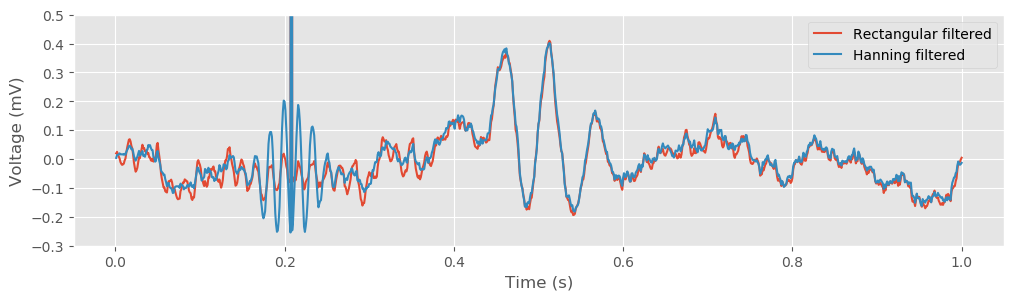

In [28]:
xf = fft(x)                       # Transform data to frequency domain,
xf_filtered_h = xf * hann_filter  # ... apply Hanning filter,
xnew_h = ifft(xf_filtered_h).real # ... transform back to time domain,
                                  # ... and plot the results.
plot(t, xnew,   label="Rectangular filtered")
plot(t, xnew_h, label="Hanning filtered")
xlabel('Time (s)')
ylabel('Voltage (mV)')
ylim([-.3, .5])
legend()
savefig('imgs/6-9b')
show()

In the first three lines of code above, the EEG data are first transformed to the frequency domain using the Fourier transform. Then the Hanning filter is applied through element-by-element multiplication. Finally, the filtered signal is transformed back to the time domain using the inverse Fourier transform. 

We can additionally compare the filters by looking at the spectra near 60 Hz:

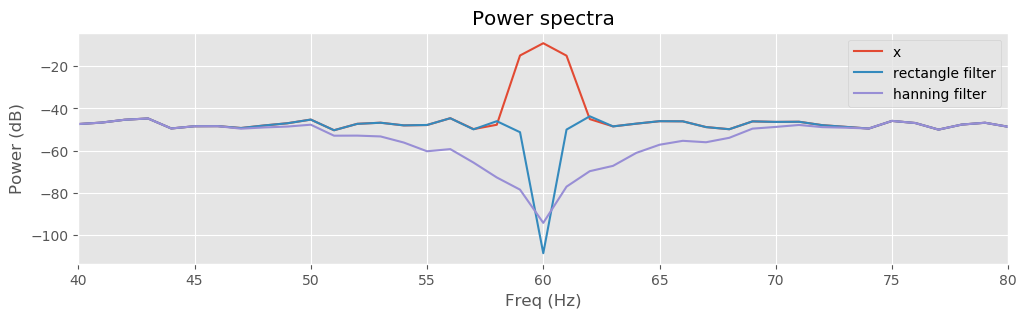

In [29]:
plot(faxis[:N//2], 10 * np.log10(spectrum(x, t)), label='x')
plot(faxis[:N//2], 10 * np.log10(spectrum(xnew, t)), label='rectangle filter')
plot(faxis[:N//2], 10 * np.log10(spectrum(xnew_h, t)), label='hanning filter')
xlim([40, 80])
xlabel('Freq (Hz)')
ylabel('Power (dB)')
title('Power spectra')
legend()
savefig('imgs/6-9a')
show()

<div class="question">
    
**Q.** Compare the results of filtering the EEG data using the naive rectangular filter and the Hanning filter. How do the filters produce similar, and different, results?

**A.** Comparison of the resulting spectra shows a sharper and deeper decrease near the 60 Hz peak for the naive rectangular filtered EEG data. In this way, the naive rectangular filter appears to far outperform the Hanning filter; the stop-band of the naive rectangular filter is more focused on eliminating the 60 Hz signal we’d like to remove. The Hanning filter is broader and reduces frequency components extending ±10 Hz around the 60 Hz peak.

However, in the time domain, the Hanning filter is far superior. The example shown above illustrates the long-range temporal effects imposed by the naive rectangular filter. Near a brief large discharge in the (unfiltered) EEG data, both filters introduce rhythmic activity for an interval of time. For the Hanning filtered data, these oscillations are a bit larger. For the naive rectangular filtered data, these oscillations persist for a much longer duration; notice that small-amplitude (60 Hz) oscillations appear from time 0 s to time 0.4 s.

</div>

Having filtered the EEG data in two ways and analyzed the results, we may now make an important conclusion: the naive rectangular filter is a poor choice. Although this filter performs admirably in the frequency domain, the results in the time domain are unacceptable. The naive rectangular filter may confound our understanding of the EEG signal through incorporation of new, long-duration temporal effects in the filtered signal. These results suggest the Hanning filter is a better choice. **However, we do not recommend using this filter.** Instead, we recommend the much safer choice of using filters designed in preexisting software functions. We describe one example of this approach in the next section.

[Back to Top](#top)
<a id="advanced-filters"></a>
### More Sophisticated Filtering

In the previous section, we designed two filters. To do so, we started in the frequency domain and applied concepts developed in previous modules when studying the spectrum (chapters [3](../03) and [4](../04)). We undertook this initial approach for one purpose: to build intuition. Developing such intuition is critical; without it, filtering would be hard to understand. However, in practice, we do not recommend the use of the naive rectangular filter or the Hanning filter. This point is so important, we further emphasize it.

<div class="warning">

Do *not* use the naive rectangular filter or the Hanning filter on your data.

</div>

Instead, we recommend using preexisting filter design methods provided for Python or other software. In this section, we illustrate the implementation and application of one such method. We continue to use the visualization techniques developed in the previous section to analyze the time and frequency domain representations of the implemented filter. We then apply the filter to the EEG data and examine the results.

#### The Finite Impulse Response (FIR) Filter: An Example.

The most common category of filter applied in neuroscience applications is the finite impulse response (FIR) filter. The name for this approach is actually quite informative. In the previous section, we defined the impulse response; it represents the response of the filter to a signal composed of only a single impulse. “Finite impulse response” indicates that the impulse response consists of only a finite number of nonzero terms. The naive rectangular filter was an example of an infinite impulse response; to represent the naive rectangular filter in the time domain requires an infinite number of terms.<sup><abbr title="In practice, all digital filters are finite. We have only a finite amount of computer memory in which to store the filter. In theory, the impulse response of the naive rectangular filter decays to zero as time approaches infinity and therefore contains nonzero contributions for an infinite number of terms.">note</abbr></sup> We found that such a broad response in the time domain produces unwanted temporal effects in the filtered signal. Here, we instead implement a filter with only a finite number of nonzero terms in the impulse response.

Before using packaged routines to create a FIR filter, we might consider how to design our own. A straightforward approach would be to start with an existing filter we developed (e.g., either the naive rectangular filter or the Hanning filter) and truncate the number of terms in the impulse response. By doing so, we would necessarily create a finite impulse response function; all terms beyond a chosen time point would be set to zero. We would therefore eliminate contributions to the filtered signal from inputs far into the past or future. That’s the right idea, but we do not pursue this approach. Instead, we use packaged functions. In this way, we leverage the expertise already inherent in these preexisting filter design approaches.

We focus specifically on the application of a lowpass FIR filter to the EEG data. We use the `firwin()` command in from the [SciPy Signal module](https://docs.scipy.org/doc/scipy/reference/signal.html) to design this filter and then apply it using the convolution function we defined earlier. We then visualize the filter and impulse response in the time and frequency domains. Let’s import the module, define useful parameters, and then design the filter:
<a id="fig:10a"></a>


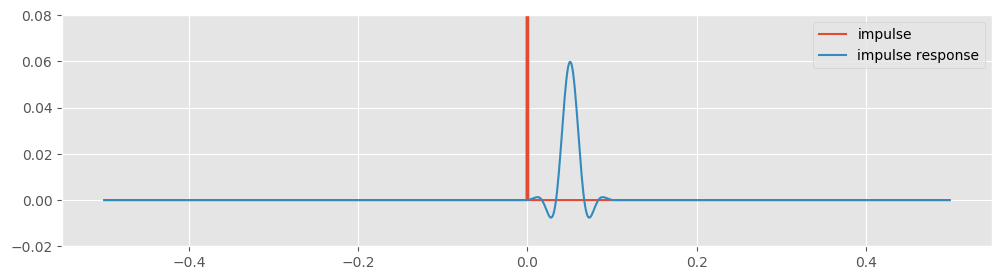

In [30]:
n = 100                                        # Define the filter order.
Wn = 30 / fNQ                                  # Define the cutoff frequency,
b = firwin(n, Wn)                              # ... build the lowpass filter,
bz = np.pad(b, [N - n, 0], 'constant')         # ... amend the filter with leading zeros,
impulse_response = convolution(impulse, bz)  # ... and apply it to the impulse.

plot(lag_axis, impulse, label='impulse')
plot(lag_axis, impulse_response, label='impulse response')
legend()
ylim([-.02, .08])
show()

Before computing the convolution, we create an augmented vector (variable `bz`). This new vector consists of leading zeros, followed by the filter (variable `b`). The augmented vector has the same length (`N`) as the impulse signal (variable `impulse`), and therefore we can compute the element-by-element multiplication of these two vectors in the same way as we did for the naive rectangular and Hanning filters. Note that the nonzero values of the filter appear at the end of the augmented vector `bz`. To compute the convolution, we shift these nonzero values over the entire length of the augmented vector, and at each shift multiply element by element the two vectors and sum their product.

Visual inspection reveals the relation between the original impulse and the filtered impulse following application of the FIR filter. We notice an important difference between the impulse response of the FIR filter and the impulse responses of the naive rectangular and Hanning filters. For the FIR filter, the peak impulse response *follows* the impulse. The reason for this delay is that the FIR filter is *causal*; to compute the convolution at any time requires only past and current values of the input signal. The naive rectangular and Hanning filters required both past and future values of the input signal. Those filters were noncausal.

To further explore this idea, let’s examine in more detail the computation of the FIR filter. Notice that to design the filter we call the `firwin()` with two inputs. The first input specifies the filter order, which corresponds to the number of nonzero terms in the filter. We specify a filter order of `n=100`. We next specify the upper frequency for the lowpass filter, which we set to 30 Hz. Notice that the frequency is specified as a fraction of the Nyquist frequency. In this case, we implement a lowpass filter; this filter will pass frequencies below 30 Hz and stop frequencies above 30 Hz. We choose a lowpass filter in this case for physiological reasons; scalp EEG data are often corrupted by muscle artifacts at frequencies above 20–30 Hz. Therefore, in an attempt to better isolate true brain signals and extract an evoked response, we apply a lowpass filter to the EEG data.

<div class="python-note">
    
**_Note_**: If we had wanted to make a highpass filter, we could have indicated this with additional arguments to `firwin()`; use `firwin?` to read the documentation.

</div>

To examine this filter, let’s break down what it does and visualize it in the time and frequency domains. In the time domain, we have already computed the impulse response using the convolution:

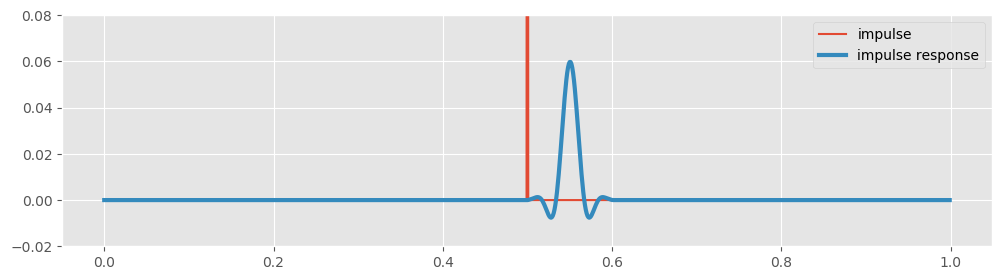

In [31]:
plot(np.arange(0, N) * dt, impulse, label='impulse')                          # Plot the original impulse,
plot(np.arange(0, N) * dt, impulse_response, lw=3, label="impulse response")  # ... and the impulse response.
ylim([-.02, .08])                                                             # ... with axes labeled
legend()
savefig('imgs/6-10a')
show()

Now, let's examine this computation closely to understand why there is a lag. To compute the FIR filter, we first constructed the augmented filter vector. To align the filter peak with the impulse requires that we (circularly) shift the augmented filter vector. In this example, the peak in the augmented filter vector (`bz`) occurs at index $N - n/2$, or equivalently, at time $(N - n/2) \cdot dt$ = 0.55 s, where $N$ is the length of the EEG data, and $n$ is the filter order. We must therefore (circularly) shift the augmented filter vector by $N/2 + n/2$, or equivalently, $(N/2 + n/2) \cdot dt$ = 0.55 s, to align it with the peak of the impulse (which occurs at index $N/2$, or equivalently, at time $N/2 \cdot dt$ = 0.5 s). The largest value in the resulting convolution therefore occurs at an index $n/2$ (or equivalently, 0.05 s) past the impulse in the original signal. The delay between the impulse and impulse response in the plot above corresponds to $n/2$ indices, or 0.05 s.

<div class="question">
    
**Q.** What are the implications of the delay induced by the FIR filter? How might this delay impact subsequent analysis?

**A.** We consider this question in more detail later in this module.

</div>

We may also examine the filter in the frequency domain. To do so, we compute and plot the *magnitude response*:
<a id="fig:10b"></a>

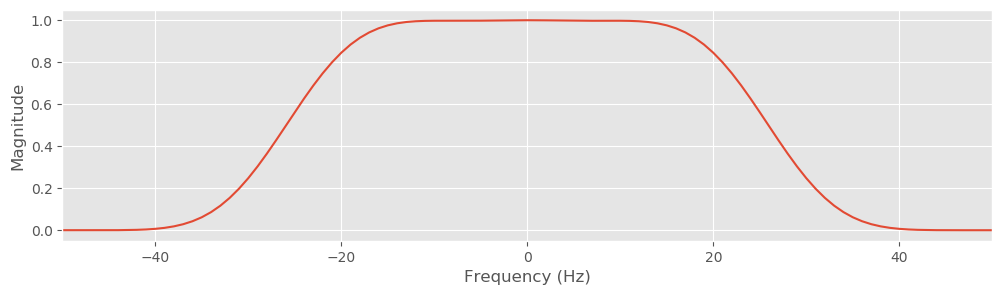

In [32]:
bf = fft(b, N);                 # Transform filter to frequency domain and compute the response
Mb = bf * bf.conj();            # ...and compute the magnitude response.
df = 1 / (N * dt)               # Define the frequency resolution,
faxis = fftfreq(N, dt);         # ...create frequency axis,
sort_order = np.argsort(faxis)  # ...with axes sorted,
plot(faxis[sort_order], Mb.real[sort_order])   # ...plot magnitude response.
xlim([-50, 50])
xlabel('Frequency (Hz)')
ylabel('Magnitude')
savefig('imgs/6-10b')
show()

We take the Fourier transform of the filter, with zero padding (see [chapter 4](../04)) to match the size of the EEG data, and compute the product of the Fourier transform of the filter and its complex conjugate. We then define the frequency axis, and plot the sorted frequency axis to avoid any unwanted lines.

<div class="question">

**Q.** Describe the behavior of the FIR filter in the frequency domain. What frequencies are passed? What frequencies are stopped?

**A.** Inspection of the magnitude response shows that frequencies between approximately &plusmn;30 Hz are passed; within this interval, the magnitude response of the filter is above zero. Beyond this interval, the magnitude response decreases to zero. Frequencies greater than 30 Hz or less than -30 Hz are removed in the filtered signal.

</div>

Having analyzed the filter through inspection of its impulse response and magnitude response, let’s now apply this filter to the EEG data:
<a id="fig:11a"></a>

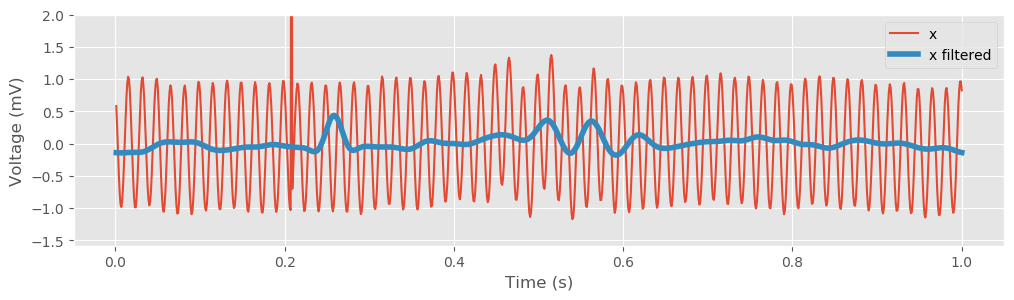

In [33]:
xnew_fir_conv = convolution(x, bz)                 # Apply the FIR filter to the data.
plot(t, x, label='x')                              # Plot the data,
plot(t, xnew_fir_conv, lw=4, label='x filtered')   # ... and the filtered data,
legend()
xlabel('Time (s)')                                 # ... with axes labeled.
ylabel('Voltage (mV)')
ylim(ymax=2)
savefig('imgs/6-11a')

Inspection of the resulting filtered signal reveals important features of the new time series. Perhaps the most prominent change is the large reduction in the 60 Hz electrical noise. Without the contamination of this noise, we now observe a transient oscillatory event near 0.5 s. As expected, the spectrum is now dominated by low-frequency activity, namely, rhythms below 30 Hz: 
<a id="fig:11b"></a>

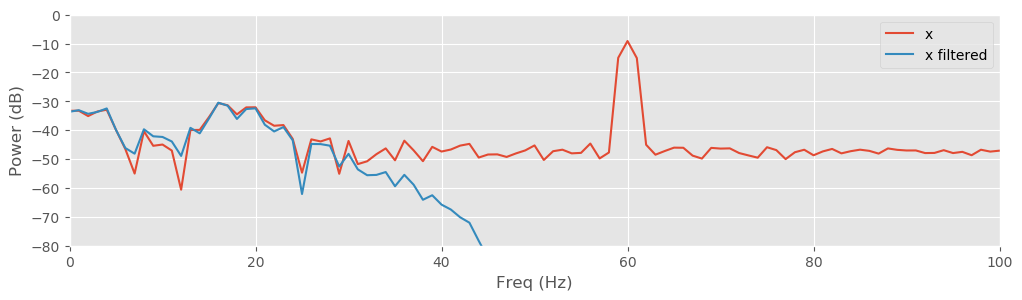

In [34]:
plot(faxis[:N // 2], 10 * np.log10(spectrum(x, t)), label='x')                 # Spectrum of data.
plot(faxis[:N // 2], 10 * np.log10(spectrum(xnew_fir_conv, t)), label='x filtered') # Spectrum of filtered data.
xlim([0, 100])
ylim([-80, 0])
xlabel('Freq (Hz)')
ylabel('Power (dB)')
legend()
savefig('imgs/6-11b')
show()

Finally, let's compare the filtered signal using the different filtering methods discussed:
<a id="fig:11c"></a>

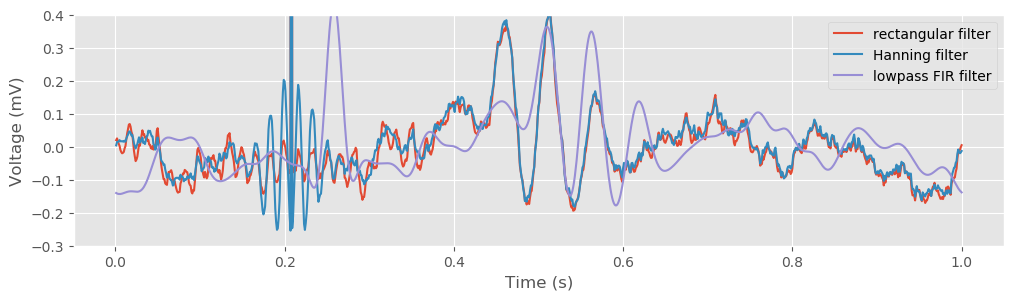

In [35]:
plot(t, xnew,     label='rectangular filter')         # Plot the results using the rectangular filter, 
plot(t, xnew_h,   label='Hanning filter')             # ... the Hanning filter,
plot(t, xnew_fir_conv, label='lowpass FIR filter')    # ... and the lowpass FIR.
ylim([-.3, .4])                                       # Narrow the y axis
legend()                                              # Label each line
xlabel('Time (s)')                                    # Label the axes
ylabel('Voltage (mV)')
savefig('imgs/6-11c')
show()

The lowpass filter alters the sharp, brief discharge in the original EEG signal (near 0.2 s) in two important ways. First, we directly observe the temporal shift introduced by the FIR filter; the peak in the filtered signal follows the large voltage deviation in the original signal by 0.05 s<a class="sup" href="#fig:11a">fig<img src="imgs/6-11a.png"></a>). Second, the FIR filter acts to reduce and broaden the large voltage deviation in the original EEG signal, consistent with the impulse response for this filter<a href="#fig:10a" class="sup">fig<img src="imgs/6-10a.png"></a>).

<div class="question">
    
**Q.** Why would a lowpass filter act to reduce and broaden a brief large discharge in the EEG?

**A.** Consider the spectrum of a simpler time series that consists of all zeros except for a single value of 1 at some time index; for example, the simple time series we use to compute the impulse response of a filter. The corresponding spectrum will have nonzero contributions at all frequencies, i.e., representing an impulse requires a combination of sinusoids at many frequencies. Conceptually, an impulse is difficult to represent as a sum of sinusoids. A single sinusoid exists (theoretically) for all time, and we’d somehow like to use these long-duration functions to represent a brief-duration impulse. If we now eliminate some of these sinusoids (e.g., by lowpass filtering the data) we corrupt the representation of the impulse; without these sinusoids, we’re no longer able to accurately represent the sharp, brief impulse in time. Instead, we create an impulse that’s broader and shorter.<span class="sup">fig<img src="imgs/6-10a.png"></span> That’s the best we can do to represent the impulse with the sinusoids we’re given, i.e., the sinusoids with frequency less than 30 Hz. In this way, the lowpass filter acts to smooth the brief large discharge in time.

</div>

Finally, inspection of the filtered signal<a href="#fig:11c" class="sup">fig<img src="imgs/6-11c.png"></a> reveals an important advantage over the naive rectangular filter. The small-amplitude 60 Hz activity produced by the naive rectangular filter does not appear in the FIR filtered data. Because the FIR filter acts more locally in time (the impulse response is finite), this filter does not produce the long-lasting temporal effects of the naive rectangular filter. We also note the clear delay induced by the FIR filter compared to the naive rectangular filter.

In the preceding code, we applied the FIR filter by computing the convolution. To conclude this section, we introduce a function from the [SciPy Signal module](https://docs.scipy.org/doc/scipy/reference/signal.html) to apply the FIR filter:

    xnew_lfilt = lfilter(b, 1, x)
    
Here, we call the function `lfilter()` with three arguments. The first argument is the FIR filter we designed at the beginning of this section using the `fir1` command. The second input (a value of 1) is appropriate for the FIR filter we designed here,<sup><abbr title="Different values for the second input allow specification of different filter types (e.g., a Butterworth filter) but are not considered here. Consult the documentation for more details.">note</abbr></sup> and the last input is the EEG signal from trial 1. Let's now plot the signal filtered in this way:

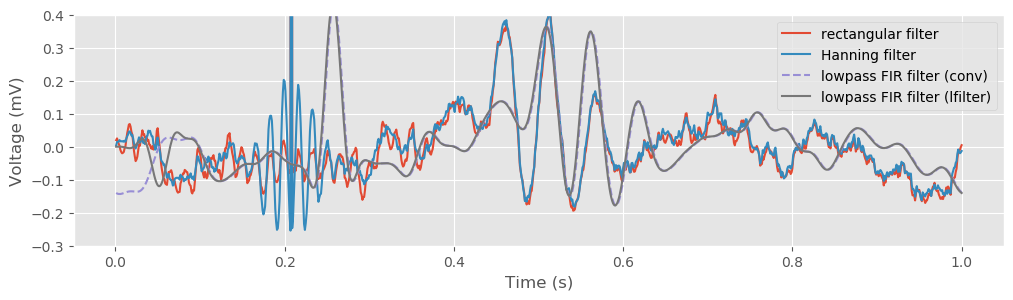

In [36]:
xnew_lfilt = lfilter(b, 1, x)                                    # Filter the signal using lfilter.
plot(t, xnew, label='rectangular filter')                        # Plot the results using the rectangular filter, 
plot(t, xnew_h, label='Hanning filter')                          # ... the Hanning filter,
plot(t, xnew_fir_conv, '--', label='lowpass FIR filter (conv)')  # ... and convolution with the lowpass FIR.
plot(t, xnew_lfilt, label='lowpass FIR filter (lfilter)')        # ... and using lfilter with the lowpass FIR.
ylim([-.3, .4])                             # Narrow the y axis
legend()                                    # Label each line
xlabel('Time (s)')                          # Label the axes
ylabel('Voltage (mV)')
savefig('imgs/6-11c')
show()

 We see that after an initial transient, the filtered signal computed using the `lfilter()` function, and the filtered signal computed explicitly using the convolution produce the same result.

<div class="question">
    
**Q.** Apply the FIR filter to the EEG data without using convolution or `lfilter()`. Instead, only use the Fourier transform and inverse Fourier transform. Do you find results consistent with the other two computations? *Hint*: You should.

</div>

To summarize, the design and application of a lowpass FIR filter can be performed in two simple steps:

    b = firwin(n, Wn)              # Design the lowpass filter, 
    xnew_lfilt = lfilter(b, 1, x)  # ... and apply it to the signal x
    
To actually execute these lines of code, we must first define the filter parameters (i.e., the filter order and the cutoff frequency), but the essence of the filtering procedure is captured here. These two lines make the process of filter design and application simple but potentially obfuscate what the filter actually does. We therefore did not immediately implement a filter in this way. Instead, we first examined intuitive ideas for filter design (e.g., the naive rectangular filter and Hanning filter) and visualizations. We expect that these initial examples will provide insight to the packaged routines. In practice, application of these routines is typically the best choice when analyzing your own data.

[Back to Top](#top)
### What's Phase Got to Do with It?<a id="phase"></a>

We saw in the previous section that the FIR filter (implemented using the `lfilter()` function) introduced a time shift in the resulting signal; this shift appeared in both the <a href="#fig:10a" class="fig">impulse response<span><img src="imgs/6-10a.png"></span></a> and in application to the <a href="#fig:11a" class="fig">EEG signal<span><img src="imgs/6-11a.png"></span></a>. In many applications, we’re interested in the precise timing of neural events. For example, if we’d like to understand the EEG response following a stimulus presentation, we must carefully preserve the timing of EEG features. We discuss in [chapter 7](../07) a specific context in which such timing of features is important to preserve (e.g., cross-frequency coupling). In these contexts and others, shifts in the EEG signal must be either well understood and accounted for, or avoided.

To assess how a filter impacts a signal, we develop another visualization technique. Recall that the Fourier transform of a signal consists of both a real and an imaginary component, or equivalently, a magnitude and phase in the complex plane (see, for example, the discussion of phase in [chapter 5](../05)). We have already discussed how to visualize the <a href="#fig:10b" class="fig">magnitude response<span><img src="imgs/6-10b.png"></span></a> of a filter. We now consider a second visualization in the frequency domain: the phase response. The phase response is similar to the magnitude response in that both are frequency domain visualizations of the filter. The primary difference is that the phase response illustrates the impact of the filter on phase at each frequency.

Let’s compute the phase response for the lowpass FIR filter. We first construct this filter using the same procedure as above, and then compute and display the phase response. Repeating some commands from previous sections for completeness,

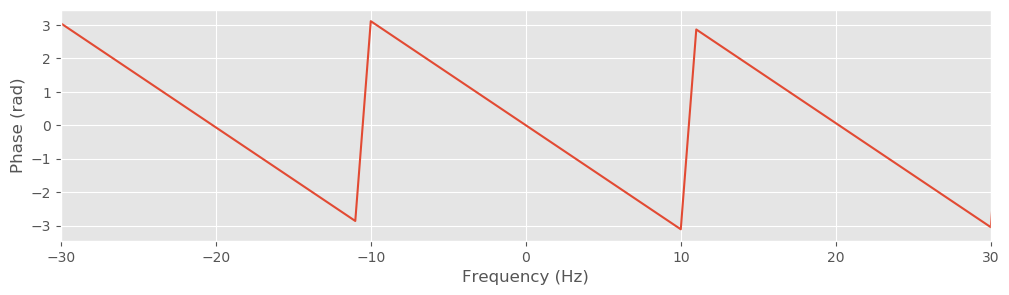

In [37]:
data = loadmat('EEG-1.mat')             # Load the data,
eeg = data['EEG']                       # ... extract the relevant variables,
t = data['t'][0]
x = eeg[0]                              # ... and analyze the first trial.

N = len(x)                              # Define no. of points in trial.
dt = t[1] - t[0]                        # Define the sampling interval.
fNQ = 1 / dt / 2                        # Define the Nyquist frequency,
df = 1 / (N * dt)                       # ... and the frequency resolution,
faxis = fftfreq(N, dt);                 # ... create frequency axis,
sort_order = np.argsort(faxis)          # ... with axes sorted.

n = 100                                 # Define the filter order,
Wn = 30 / fNQ                           # ... specify the cutoff frequency,
b = firwin(n, Wn)                       # ... build lowpass filter.
bf = fft(b, N)                          # Transform filter to frequency domain,
plot(faxis[sort_order], angle(bf[sort_order]))  # ... and plot phase response.

xlim([-30, 30])                         # Examine a specific frequency range,
xlabel('Frequency (Hz)')                # ... with axes labeled.
ylabel('Phase (rad)')
savefig('imgs/6-12a')
show()

We first load the data and define the frequency axis. We then construct the lowpass FIR filter and plot the phase response versus frequency (with axes sorted to avoid spurious features in the plot). Note that we use the function `angle()` to determine the phase of the vector `bf`. We focus on the passband (from -30 Hz to 30 Hz) because signals outside of this band are greatly reduced by the filter and not relevant in the filtered signal.

<div class="question">
    
**Q.** Examine the phase response. How does the phase vary with frequency within the passband (i.e., for frequencies between &plusmn;30 Hz)?

**A.** Visual inspection reveals that the phase response varies with frequency. This variation is linear except for discrete jumps occurring at &plusmn;$\pi$. To make this linear variation clear, we can unwrap the phase:

    plot(faxis[sort_order], np.unwrap(angle(bf[sort_order])))
    
Notice the application of the `unwrap` function to the angle computed in this line of code. With the phase unwrapped, the smooth and linear variation in the phase response versus frequency becomes clear. The wrapped phase response allows us to identify frequencies at which the filter phase advances the signal (e.g., when the phase response is positive, such as at 15 Hz), when the filter phase delays the signal (e.g., when the phase response is negative, such as at 25 Hz), or when the filter leaves the phase unchanged (e.g., when the phase is zero, such as at 20 Hz).

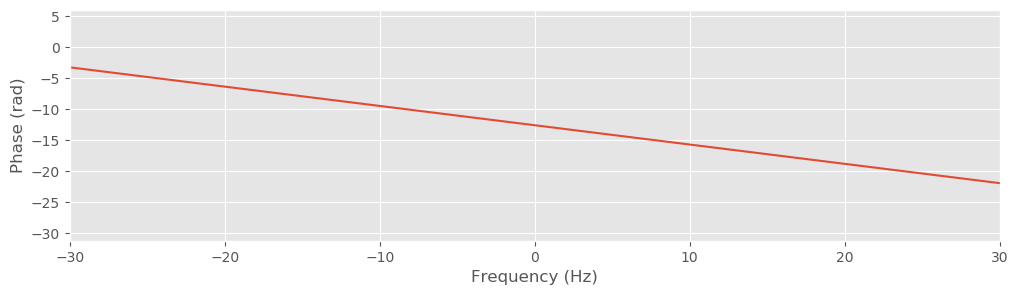

In [38]:
plot(faxis[sort_order], np.unwrap(angle(bf[sort_order])))  # Plot the unwrapped phase response
xlim([-30, 30])                         # Examine a specific frequency range,
xlabel('Frequency (Hz)')                # ... with axes labeled.
ylabel('Phase (rad)')
savefig('imgs/6-12b')
show()

Analysis of the phase response for the FIR filter shows that, consistent with our observations of the impulse response and filtered EEG data, the FIR filter alters the phase of the original signal. To eliminate this shift introduced by the filter, we apply the same filter twice to the data. First, we apply the FIR filter to the original input signal, just as we did to create the lowpass filtered EEG. This filtering operation introduces a shift (of size n/2 indices, or 0.05 s for our data) in the resulting EEG (e.g., <a href="#fig:10a" class="fig">see above<span><img src="imgs/6-10a.png"></span></a>). Second, we reverse the filtered signal and then apply this same FIR filter to the reversed sequence. The outcome of this second filtering operation is our desired signal: the filtered data without the phase shift.
<a id="fig:13"></a>

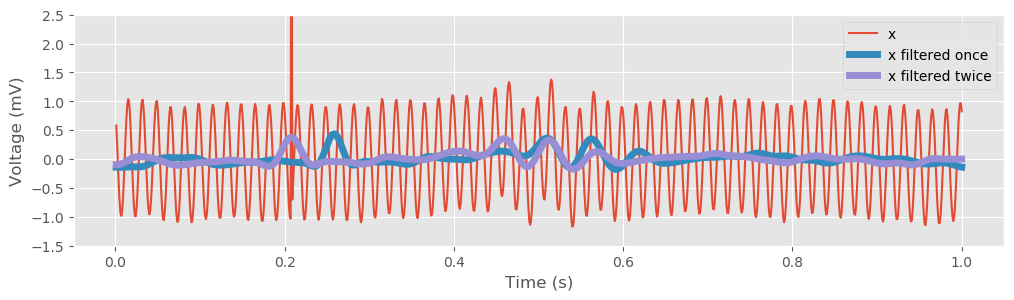

In [39]:
x1 = lfilter(b, 1, x)             # Apply the filter to the EEG data,
x1 = np.flip(x1)                  # ... reverse the sequence,
x2 = lfilter(b, 1, x1)            # ... reapply the filter,
x2 = np.flip(x2);                 # ... and reverse the sequence.

fig, ax = subplots()              # Plot the results
ax.plot(t, x, label='x')
ax.plot(t, xnew_fir_conv, lw=5, label='x filtered once')
ax.plot(t, x2, lw=5, label='x filtered twice')

ylim([-1.5, 2.5])                 # Narrow the vertical axis,
xlabel('Time (s)')                # ... and label the axes.
ylabel('Voltage (mV)')
legend()
savefig('imgs/6-13')
show()

In these lines of code, we apply the FIR filter using `lfilter()`.The first line of code applies the filter once, and the resulting filtered signal is phase shifted relative to the original EEG. We then reverse the filtered signal. To do so, we redefine the variable `x1` using `np.flip()` to reverse the sequence. We then filter the reversed sequence, and reverse the result. The resulting double-filtered (and double-reversed) signal no longer exhibits phase distortion relative to the EEG; prominent features in the original EEG signal and the zero-phase filtered signal, such as the large-amplitude discharge, appear better aligned.

In general, in neuroscience applications, it’s often useful to remove phase distortion through zero-phase filtering. The [SciPy Signal module](https://docs.scipy.org/doc/scipy/reference/signal.html) provides a simple function to perform zero-phase filtering,

    xnew_filtfilt = filtfilt(b, 1, x)  # Perform zero-phase filtering
    
The `filtfilt()` function applies the lowpass FIR filter defined by the parameters `b` to the data in the forward and reverse directions, and (ignoring transients at the beginning and end of the signal) matches our explicit approach to zero-phase filtering.

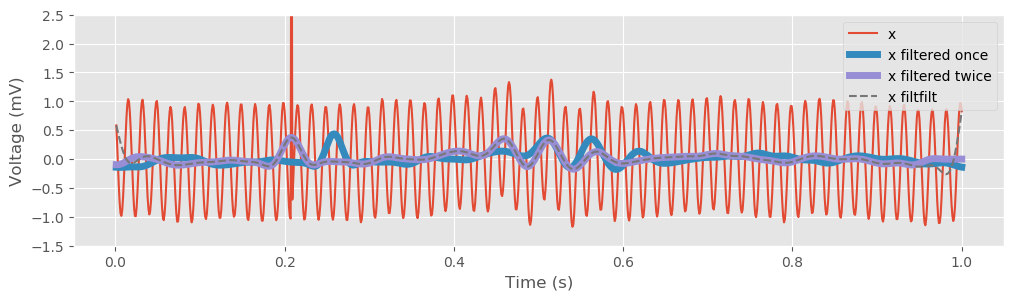

In [40]:
ax.plot(t, filtfilt(b, 1, x), '--', label='x filtfilt')
ax.legend()
fig

In the next section, we apply these commands to complete our analysis of the EEG signal.  

Before completing this section, let’s briefly consider an intuitive argument to motivate the procedure for performing zero-phase filtering. Consider the impulse response for the lowpass FIR filter of order $n = 100$ we implemented previously<a href="#fig:10a" class="sup">fig<img src="imgs/6-10a.png"></a>. An impulse at index $k$ will result in a peak at index $k + n/2$ in the filtered signal; the first filtering operation shifts the index of the peak by $n/2$. Now, consider reversing the filtered signal. For concreteness, let’s consider the case where the impulse occurs at index 800 (i.e., k = 800) and the total length of the signal is 2,000 indices. After applying the filter, the peak will occur at index $k + n/2 = 850$. Now, reverse this filtered signal; the peak will then occur at index $2000 - 850 = 1150$. We then filter this new signal, which again shifts the index of the peak by $n/2$; the new peak then occurs at index $1150 + n/2 = 1200$. Finally, we reverse the signal once more; the peak index becomes $2000 - 1200 = 800$. Through this simple example, we gain some intuition for the zero-phase filtering process. By applying the filter twice and reversing the signal appropriately, we maintain the timing of features in the original input signal.

Does applying the same filter twice to the signal impacts the results? Yes. Each time we apply the filter, we convolve the signal with the coefficients `b` determined here for the lowpass FIR filter. Each application changes the resulting signal. However, the additional distortion produced by filtering twice is compensated by the elimination of phase distortion.

[Back to Top](#top)
### Analysis of the Filtered EEG Data<a id="analysis"></a>

Having introduced some basic filtering concepts, let’s now return to the EEG data. Our primary scientific goal is to determine whether the provided EEG data exhibit an evoked response. Our initial analysis hinted that <a href="#fig:3" class="fig">an evoked response might occur<span><img src="imgs/6-3a.png"></span></a> but was hidden by the large electrical noise—and perhaps other noise—inherent in the EEG data. To reduce this noise, let’s examine the lowpass filtered EEG signal. We choose a lowpass filter to both reduce the 60 Hz electrical noise and reduce other activities associated with nonbrain signals (e.g., muscle artifacts) common in EEG data. In retrospect, the design and application of a lowpass filter with cutoff frequency is now straightforward.

In [41]:
data = loadmat('EEG-1.mat')    # Load the EEG data.
eeg = data['EEG']
t = data['t'][0]

dt = t[1] - t[0]               # Define the sampling interval.
fNQ = 1 / dt / 2               # Determine the Nyquist frequency.
K = len(eeg)                   # Determine no. of trials.

n = 100                        # Define the filter order
Wn = 30 / fNQ                  # ... and specify the cutoff frequency,
b = firwin(n, Wn)              # ... build lowpass filter.
eeg_lo = np.array([filtfilt(b, 1, eeg[k]) for k in range(K)])  # Zero-phase filter each trial

Here we use the function `firwin()` to design the filter and the function `filtfilt()` to apply the filter with zero-phase distortion. The design and application of the filter to each trial requires only a few lines of code (including the for-loop). However, we now perform this analysis with a thorough understanding of how the filter behaves; we examined its
<a href="#fig:10a" class="fig">impulse response<span><img src="imgs/6-10a.png"></span></a>,
<a href="#fig:10b" class="fig">magnitude response<span><img src="imgs/6-10b.png"></span></a>, and <a href="#fig:12" class="fig">phase response<span><img src="imgs/6-12a.png"></span></a>. Let’s now analyze the resulting filtered EEG data by computing the evoked response and average spectrum.
<a id="fig:14"></a>

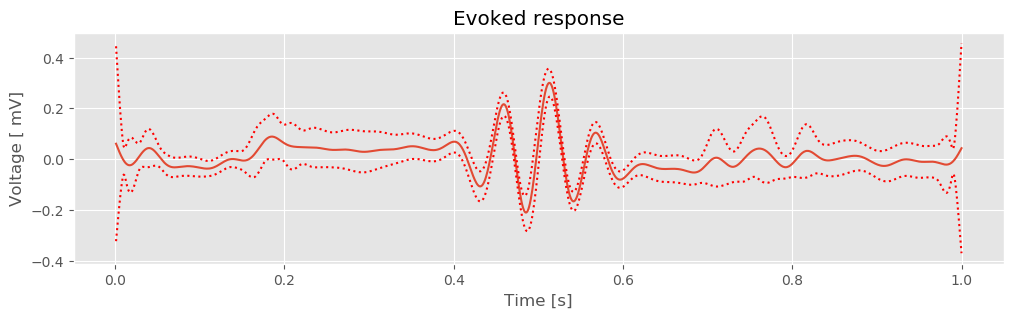

In [42]:
mn = eeg_lo.mean(0)      # Compute mean of filtered EEG across trials (ERP)
sd = eeg_lo.std(0)       # Compute std of filtered EEG data across trials.
sdmn = sd / np.sqrt(K);  # Compute the std of the mean.

plot(t, mn)                    # Plot the ERP of the filtered data
plot(t, mn + 2 * sdmn, 'r:');  # ... and the confidence intervals,
plot(t, mn - 2 * sdmn, 'r:');
xlabel('Time [s]')             # ... and label the axes.
ylabel('Voltage [ mV]')
title('Evoked response')
savefig('imgs/6-14a')
show()

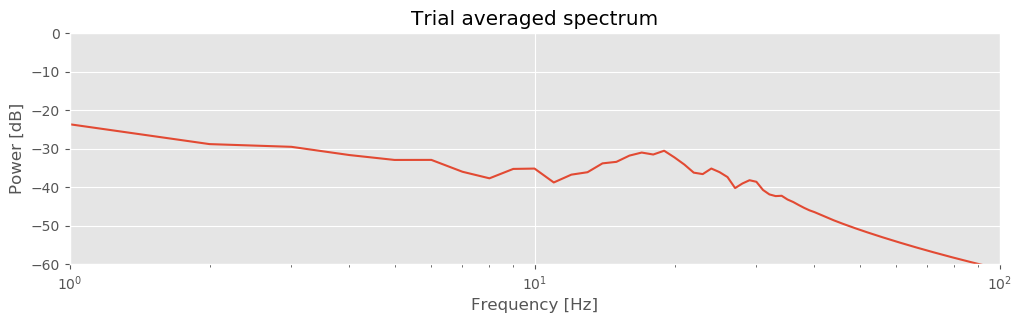

In [43]:
def spectrum(x, t, hann=True):
    '''
    Define a function that computes the power spectrum 
    for any given trial data (x) and corresponding sample time (t).
    '''
    dt = t[1] - t[0]
    T = t[-1]
    xh = hanning(len(x)) * (x - x.mean()) if hann else x - x.mean()
    xf = rfft(xh)[:-1]
    Sxx = 2 * dt ** 2 / T * (xf * xf.conj())
    return Sxx.real

N = len(t)                             # Define the number of time points per trial.
faxis = fftfreq(N, dt)[:N // 2]        # Define the positive frequency axis,
Sxx = [spectrum(trial, t, False) for trial in eeg_lo]  # Compute the spectrum for each trial.
Sxxmn = np.array(Sxx).mean(0)          # Convert the result into an array and compute the mean.
semilogx(faxis, 10 * np.log10(Sxxmn))  # Plot the result in decibels vs frequency,
xlim([df, 100])                        # ... in limited frequency range,
ylim([-60, 0])                         # ... and a limited power range,
xlabel('Frequency [Hz]')               # ... with axes labeled.
ylabel('Power [dB]')
title('Trial averaged spectrum')
savefig('imgs/6-14b')
show()

<div class="question">
    
**Q.** Compare the <a href="#fig:3" class="fig">evoked response<span><img src="imgs/6-3a.png"></span></a> and <a href="#fig:3" class="fig">spectrum<span><img src="imgs/6-3b.png"></span></a> of the original EEG data to the evoked response and spectrum of the filtered data. What features are similar? What features differ?

**A.** To compute the evoked response and average spectrum, we apply the same procedures utilized for the original data (see code [above](#evoked-response)). We now find that between approximately 0.4 s and 0.6 s, the filtered EEG signal exhibits a signifiant ERP; the 95% confidence intervals of the ERP now exclude zero in this range. We are therefore happy to report to our collaborator evidence for a significant ERP in the filtered EEG data. We also note the reduced impact in the ERP of the large, brief discharges that appear in individual trials. In the original EEG data, each discharge from an individual trial was so large that the <a href="#fig:3" class="fig">impact on the ERP was dramatic<span><img src="imgs/6-3a.png"></span></a> (e.g., consider times near 0.2 s and near 0.8 s). In the filtered EEG data, these discharges have been smoothed, and their impact greatly reduced in the ERP.

Inspection of the average spectrum for the filtered EEG data reveals power at low frequencies and perhaps a small peak at 15–25 Hz, as observed in the unfiltered EEG data. Again, we note that the approximately 15–25 Hz peak in the spectrum is consistent with the period of the transient rhythmic discharge in the ERP. The filtered data exhibit much less power spectral density at higher frequencies compared to the original EEG; this is what we expect following application of the lowpass filter.

</div>

[Back to Top](#top)
## Summary<a id="summary"></a>

We began this chapter with visual analysis of the single-trial data and computation of an ERP and trial-averaged spectrum. The spectrum revealed a large peak at 60 Hz, consistent with visual inspection of the single-trial data. The ERP showed some suggestive evidence for an evoked response; however, we did not find a significant effect. We made an initial conjecture that an interesting evoked response might occur in the data but was hidden by the large-amplitude 60 Hz noise.

To isolate the evoked response, we then focused on reducing the 60 Hz activity in the signal. We introduced the notion of filtering. We put forward two naive approaches, the naive rectangular filter, and the naive Hanning filter and developed these approaches in great detail. We defined the notion of an impulse response and examined how filtering may be equivalently applied in the frequency domain (through multiplication) or in the time domain (through convolution). Through these example filters, we observed the trade-offs that occur in the time and frequency domains. In particular, we observed that the sharp edge in the frequency domain of the naive rectangular filter created long-lasting effects in the time domain, acting to distort the original signal.

We then discussed the application of a finite impulse response (FIR) filter to the data. We showed how this filter may be easily defined and applied in Python using packaged functions. We discussed procedures to visualize a filter’s behavior, including the magnitude response and the phase response. Finally, we discussed the importance of zero-phase filtering.

We concluded by reanalyzing the EEG data. To do so, we first lowpass filtered the data and then computed the evoked response and trial-averaged spectrum. After filtering, we found a significant evoked response in the data. Consistent with our initial conjecture, the evoked response was hidden by the high-amplitude 60 Hz noise present in the original signal. Upon filtering to remove this noise, the evoked response became clear.

The design and application of filters is an enormous and rich field of study. The goal of this chapter is not a thorough discussion of filtering. Instead, we introduced only a handful of filtering concepts that motivate a basic understanding of filtering. These concepts extend directly from ideas developed to compute the spectrum in chapters [3](../03) and [4](../04). Through tools such as the Fourier transform and convolution, we are able to visualize and apply filters in the frequency and time domains. These same tools apply and provide context for alternative approaches to filtering. For further details in the design and application of filters see [[Percival & Walden, 1998](https://doi.org/10.1017/CBO9780511622762), [Priestley, 1981](https://buprimo.hosted.exlibrisgroup.com/permalink/f/1du03mk/ALMA_BOSU121668583370001161)]. We apply filters in [chapter 7](../07) to assess cross-frequency coupling in neural field data.

[Back to Top](#top)